This is for the Kaggle competition **Housing House Prediction 2022 Posgraduate DSUB_O**, that can be found [here](https://www.kaggle.com/competitions/housing-house-prediction-2022-posgraduate-dsubo).

With the ensembled model, was able to get a score of 280k in the test set, achieving the top 1 position.

In [2]:
import os
import re
import math
import typing
import warnings
from enum import Enum

import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import matplotlib as mpl
from scipy.stats import zscore
import matplotlib.pyplot as plt

import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, train_test_split, RandomizedSearchCV

from sklearn.exceptions import DataConversionWarning
from IPython.display import display, HTML
display(HTML("<style>.container { width: 90% !important}; </style>"))

In [5]:
warnings.filterwarnings(
    action='ignore',
    message='înternal gelsd'
)

warnings.filterwarnings(
    action='ignore',
    category=UserWarning
)

warnings.filterwarnings(
    action='ignore',
    category=RuntimeWarning
)

warnings.filterwarnings(
    action='ignore', 
    category=DataConversionWarning
)

In [6]:
np.random.seed(1)

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

pd.options.mode.chained_assignment = None  # default='warn'

In [7]:
# Matplotlib set label size
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

plt.rc('font', size=12)
plt.rc('figure', figsize=(12, 5))

In [8]:
sns.set_style('whitegrid')
sns.set_context(
    'notebook',
    font_scale=1,
    rc={
        'lines.linewidth': 2,
        'font.family': [u'times']
    }
)

## Loading Data

In [9]:
train_set = pd.read_csv('./data/train_set.csv', index_col=0)
test_set = pd.read_csv('./data/test_set.csv', index_col=0)

<AxesSubplot:>

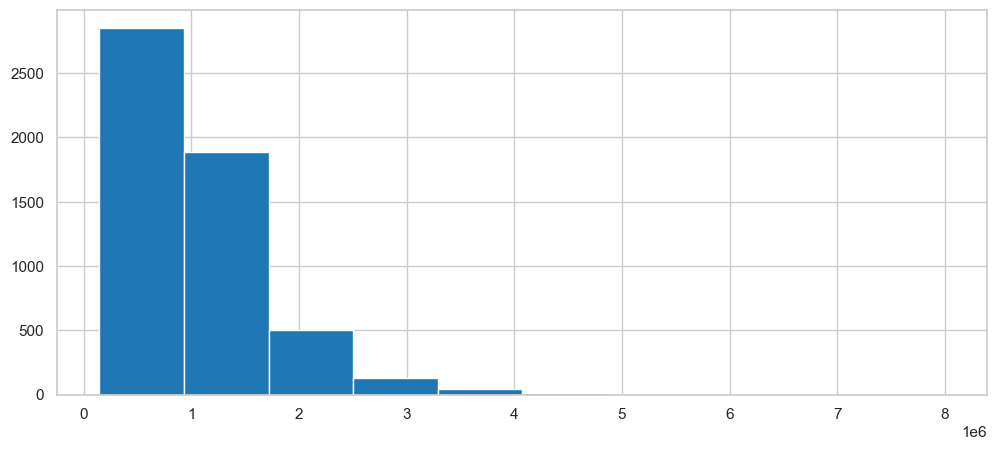

In [10]:
train_set.Price.hist()

<AxesSubplot:>

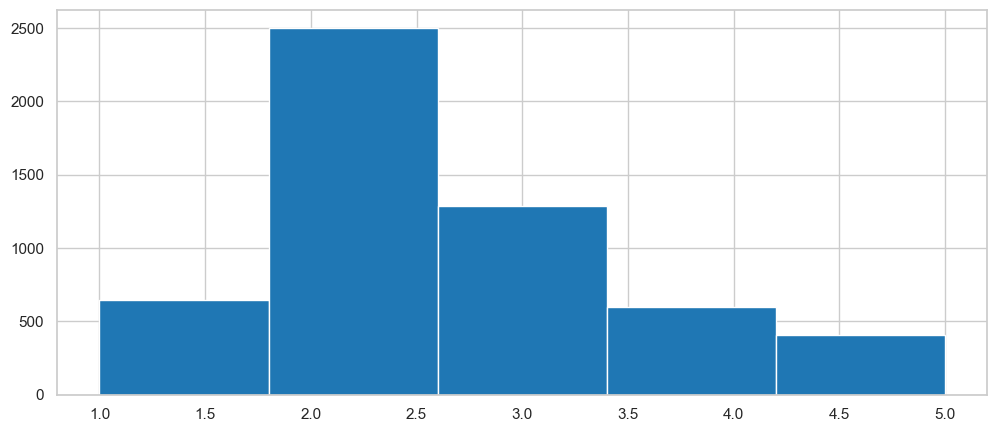

In [11]:
train_set['price_range'] = pd.cut(train_set.Price, bins=[.0, .5e6, 1e6, 1.5e6, 2e6, 10e6], labels=[1, 2, 3, 4, 5])
train_set['price_range'].hist(bins=5)

In [12]:
def train_val_split(train_set: pd.DataFrame, stratify_col: str = 'price_range'):
    train_set_target = train_set[stratify_col]

    X_train, X_valid, Y_train, Y_valid = train_test_split(
        train_set, 
        train_set_target, 
        stratify=train_set_target, 
        test_size=.15,
        random_state=0
    )
    
    return pd.concat([X_train, Y_train], axis=1), pd.concat([X_valid, Y_valid], axis=1)

In [13]:
train_set, valid_set = train_val_split(train_set)

In [14]:
train_set.drop(['price_range'], axis=1, inplace=True)
valid_set.drop(['price_range'], axis=1, inplace=True)

## EDA

In [15]:
train_set.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,4617.000000,4.617000e+03,4617.000000,4617.000000,4617.000000,4617.000000,4595.000000,4617.000000,2435.000000,2801.000000,4617.000000,4617.000000,4617.000000
mean,2.938705,1.078467e+06,10.261057,3105.903617,2.918562,1.537362,1.631338,538.927442,167.292700,1965.311674,-37.810119,144.994463,7379.346979
std,0.951790,6.454600e+05,6.038494,94.448991,0.993194,0.699995,0.990320,1614.688646,917.783312,36.274513,0.079175,0.108455,4341.521714
min,1.000000,1.450000e+05,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1830.000000,-38.174880,144.542370,389.000000
25%,2.000000,6.500000e+05,6.200000,3044.000000,2.000000,1.000000,1.000000,185.000000,92.000000,1940.000000,-37.857100,144.927500,4217.000000
50%,3.000000,9.000000e+05,9.200000,3084.000000,3.000000,1.000000,2.000000,451.000000,125.000000,1970.000000,-37.803500,144.999400,6543.000000
75%,3.000000,1.331000e+06,13.000000,3148.000000,3.000000,2.000000,2.000000,656.000000,175.000000,2000.000000,-37.757690,145.058790,10331.000000
max,8.000000,8.000000e+06,48.100000,3977.000000,20.000000,8.000000,10.000000,75100.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000


<AxesSubplot:xlabel='Type', ylabel='count'>

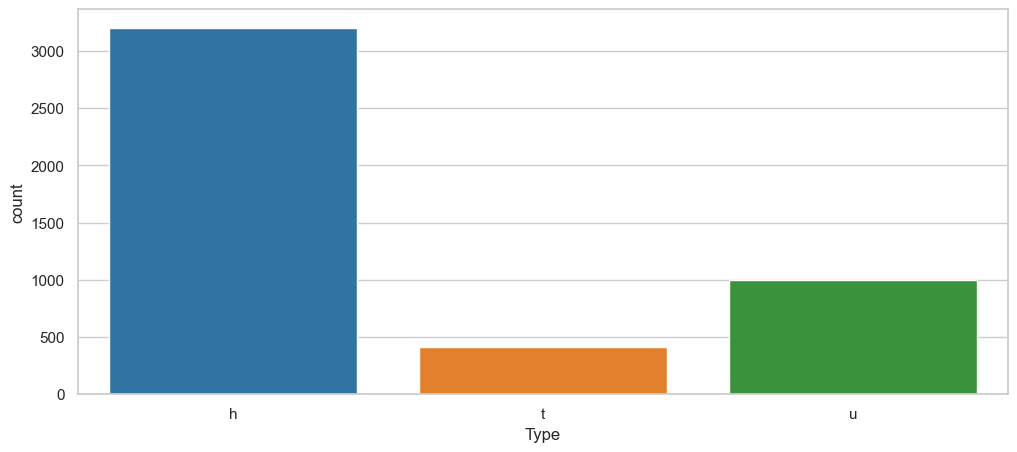

In [16]:
sns.countplot(x='Type', data=train_set)

<AxesSubplot:xlabel='Longtitude', ylabel='Lattitude'>

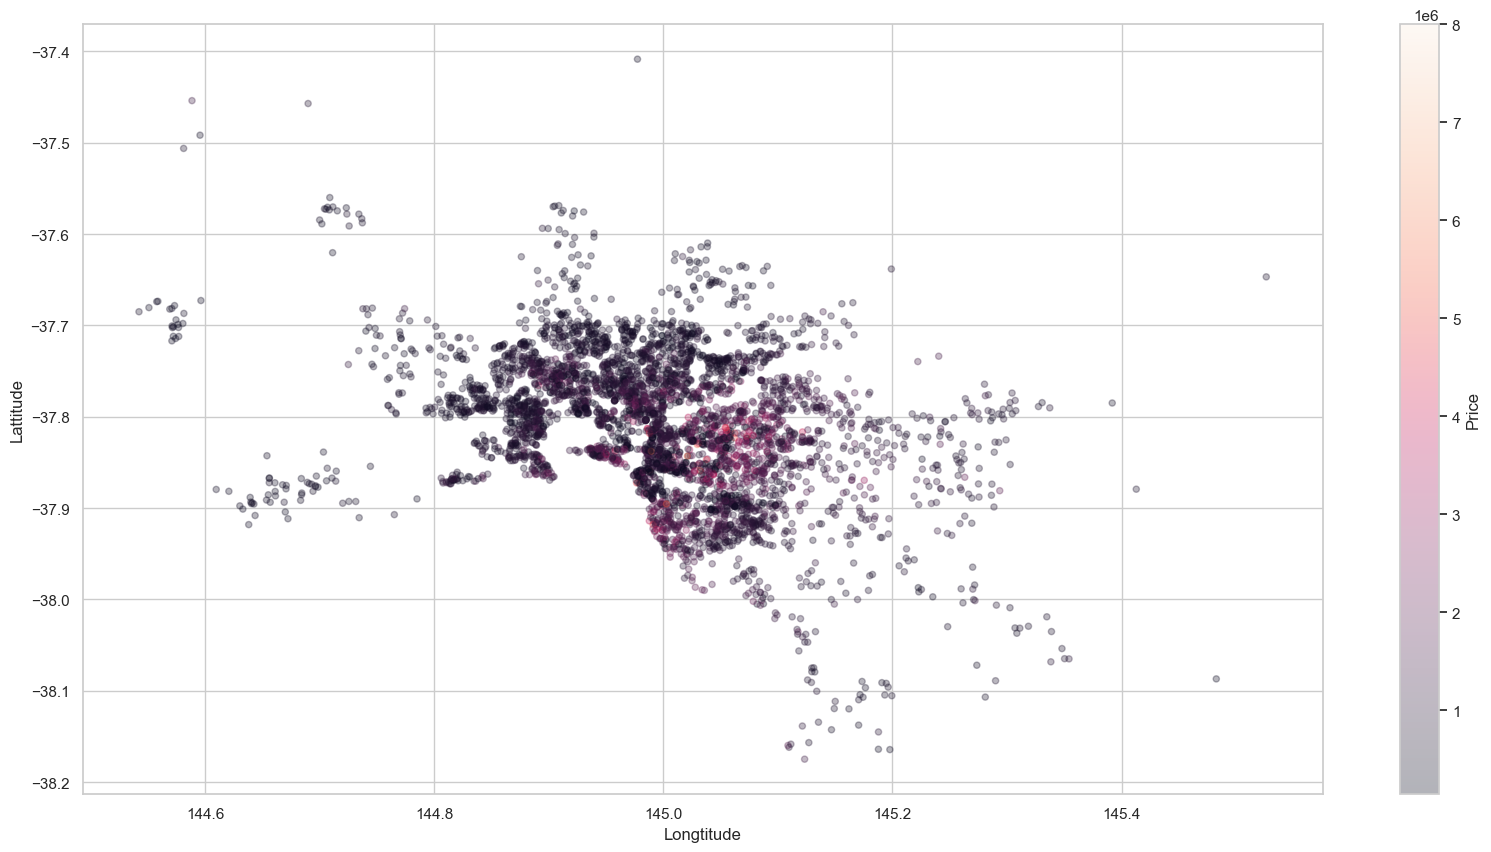

In [17]:
train_set.plot(
    kind='scatter',
    x='Longtitude',
    y='Lattitude',
    alpha=.3,
    figsize=(20, 10),
    c='Price', 
    cmap=plt.get_cmap('jet'),
    colorbar=True,
    sharex=False
)

<AxesSubplot:>

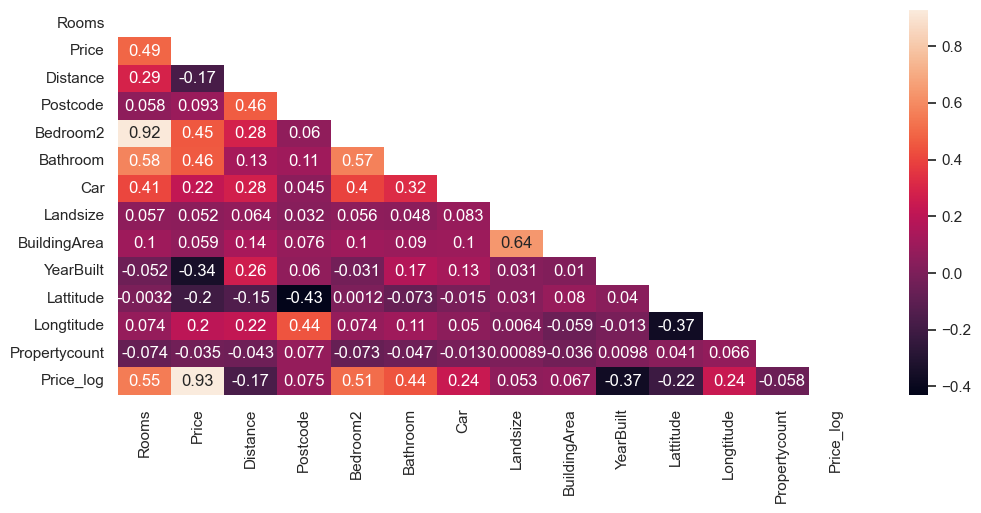

In [18]:
train_set.loc[:, 'Price_log'] = np.log(train_set['Price'])
corr = train_set.corr(numeric_only=True)

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

sns.heatmap(
    corr,
    annot=True,
    mask=matrix
)

In [19]:
corr_sorted = corr['Price'].sort_values()
corr_sorted

YearBuilt       -0.344287
Lattitude       -0.204988
Distance        -0.174566
Propertycount   -0.035337
Landsize         0.051705
BuildingArea     0.059124
Postcode         0.092615
Longtitude       0.200117
Car              0.219901
Bedroom2         0.450831
Bathroom         0.457246
Rooms            0.488317
Price_log        0.927824
Price            1.000000
Name: Price, dtype: float64

In [20]:
corr_sorted = corr['Price_log'].sort_values()
corr_sorted

YearBuilt       -0.370563
Lattitude       -0.216350
Distance        -0.167657
Propertycount   -0.058089
Landsize         0.053004
BuildingArea     0.066616
Postcode         0.075252
Longtitude       0.239240
Car              0.242657
Bathroom         0.442409
Bedroom2         0.513359
Rooms            0.553088
Price            0.927824
Price_log        1.000000
Name: Price_log, dtype: float64

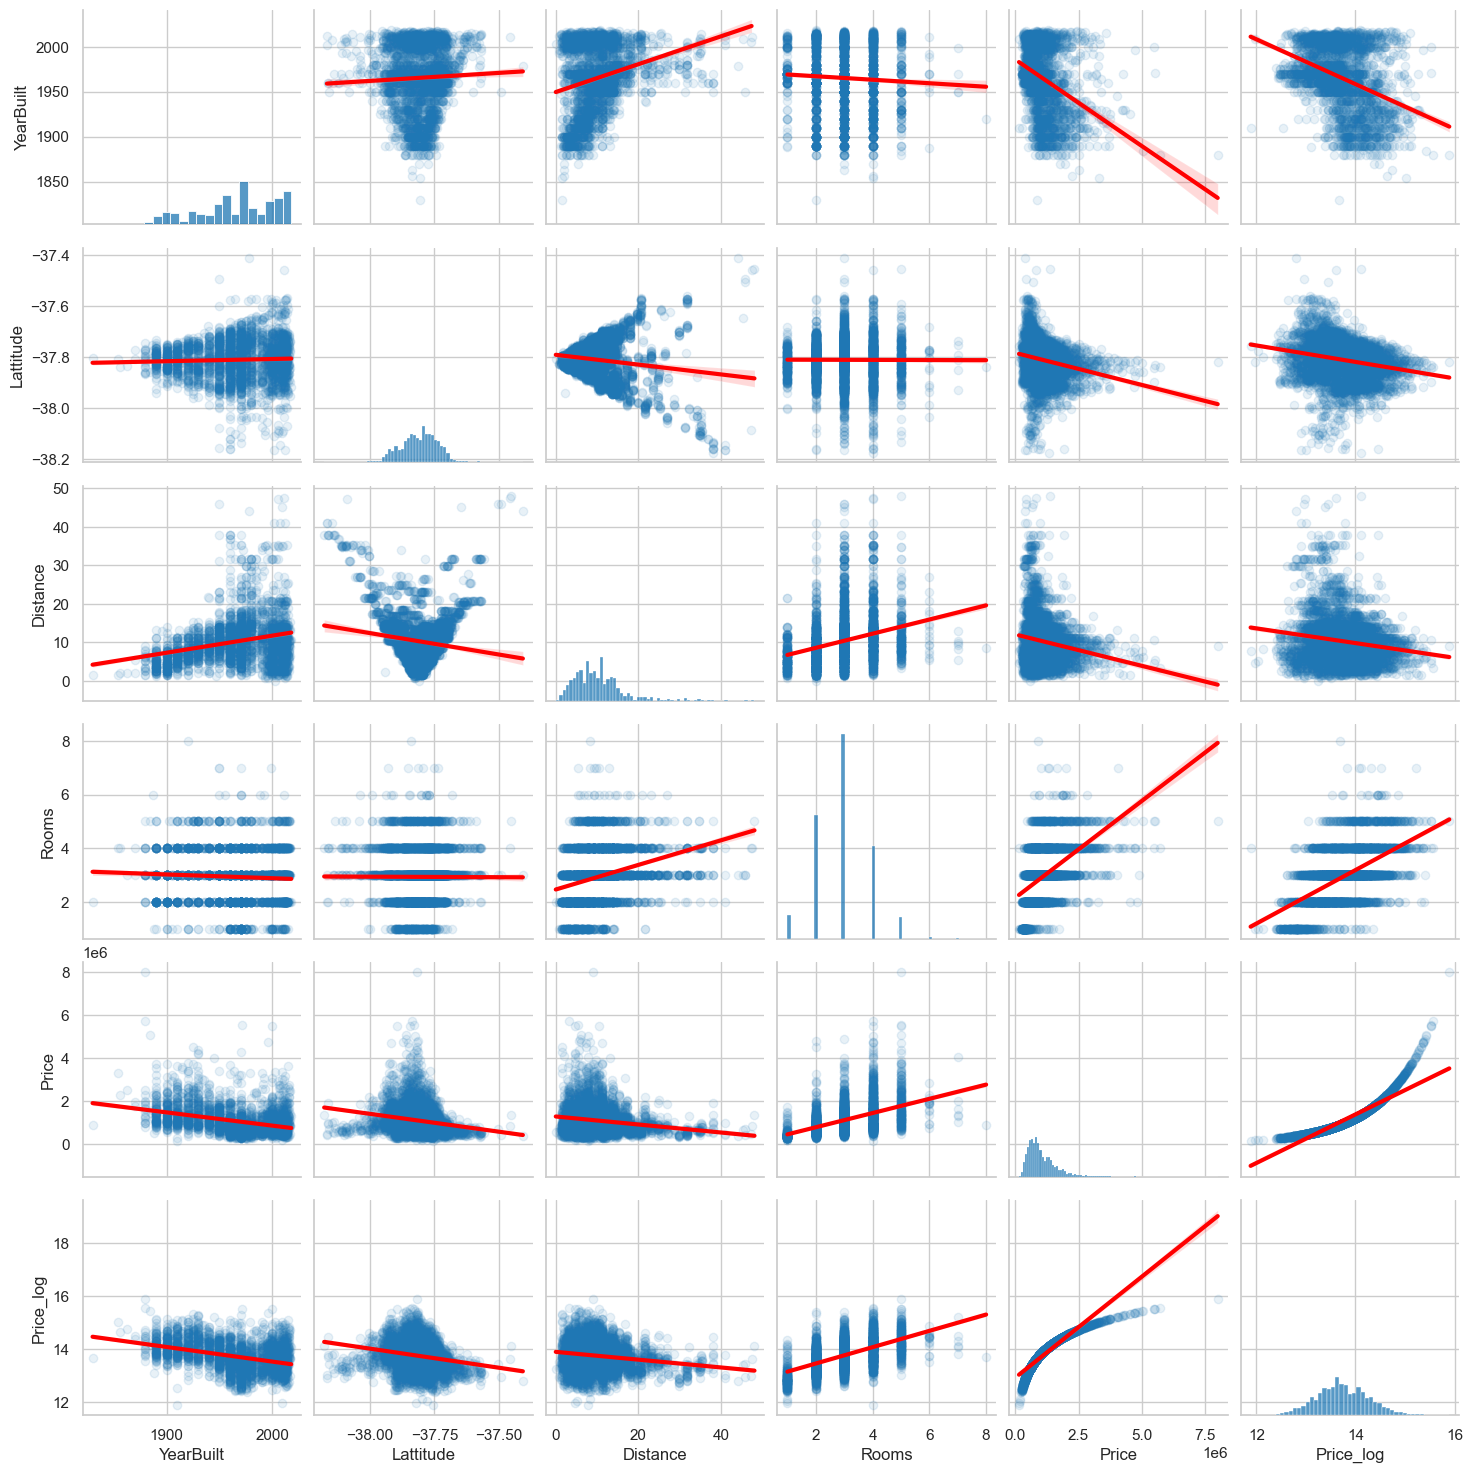

In [21]:
# Will do pair plot with most correlated values
sns.pairplot(
    train_set[corr_sorted.index[:3].tolist() + corr_sorted.index[-3:].tolist()],
    kind='reg',
    plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}}
)

## Data Processing

In [22]:
print(train_set.isnull().sum(axis=0).to_string())

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                22
Landsize            0
BuildingArea     2182
YearBuilt        1816
CouncilArea       477
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
Price_log           0


In [23]:
train_set_processed = train_set.copy()
valid_set_processed = valid_set.copy()
test_set_processed = test_set.copy()

Decided not to handle outliers, but create models that are robust to them. As outliers are a valid data from our dataset.

### Handling NaNs

#### Car

<AxesSubplot:xlabel='Price', ylabel='Count'>

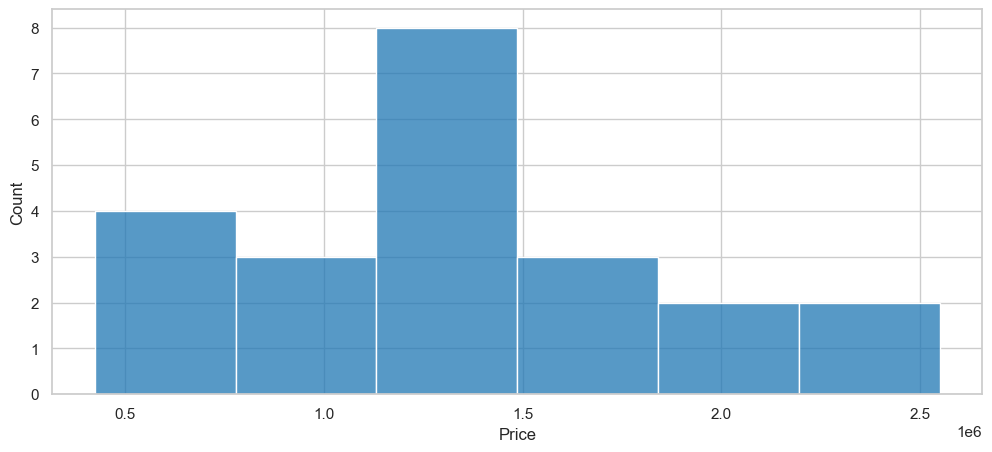

In [24]:
# How is the distribution of price when car is not set
sns.histplot(
    train_set_processed[train_set_processed.Car.isnull()]['Price']
)

In [25]:
def handle_null_car(train_df, valid_df, test_df, year_not_car: int = 1940):
    """
    We will assume that for the nulls in the year before year_not_car, are because there as effectively no car.
    
    """
    
    # For the other ones would place the median
    train_set_median = train_df['Car'].median()
    
    # For very aged houses
    train_df.loc[
        train_df['YearBuilt'] < year_not_car,
        'Car'
    ] = 0

    valid_df.loc[
        valid_df['YearBuilt'] < year_not_car,
        'Car'
    ] = 0

    test_df.loc[
        test_df['YearBuilt'] < year_not_car,
        'Car'
    ] = 0
    
    
    # And for the other houses
    train_df['Car'].fillna(train_set_median, inplace=True)
    valid_df['Car'].fillna(train_set_median, inplace=True)
    test_df['Car'].fillna(train_set_median, inplace=True)
    
    return train_df, valid_df, test_df

In [26]:
train_set_processed, valid_set_processed, test_set_processed = handle_null_car(train_set_processed, valid_set_processed, test_set_processed)

####  BuildingArea

In [27]:
def get_df_valid_size(df: pd.DataFrame, column: str):
    return df[
        (~df[column].isnull()) &
        (df[column] > 0)
    ]

In [28]:
def get_df_invalid_size(df: pd.DataFrame, column: str):
    return df[
        (df[column].isnull()) |
        (df[column] <= 0)
    ]

In [29]:
# We can see that half of the dataset is not useful
building_area_train_base = get_df_valid_size(train_set_processed, 'BuildingArea')
building_area_train_target = get_df_invalid_size(train_set_processed, 'BuildingArea')

print('Valid building area shape: ', building_area_train_base.shape)
print('Invalid building area shape: ', building_area_train_target.shape)

Valid building area shape:  (2429, 22)
Invalid building area shape:  (2188, 22)


We can try to find an easy relationship to the building area.

In [30]:
building_area_train_base.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Price_log
index,,,,,,,,,,,,,,,,,,,,,,
1845,Kensington,51 Rankins Rd,2,h,765000.0,S,Nardella,10/12/2016,4.2,3031.0,2.0,1.0,2.0,158.0,76.0,1965.0,Melbourne,-37.7902,144.9319,Northern Metropolitan,5263.0,13.547631
1609,Hawthorn East,3 Jaques St,5,h,2500000.0,VB,RT,22/08/2016,7.5,3123.0,5.0,3.0,0.0,757.0,240.0,1925.0,Boroondara,-37.8176,145.0548,Southern Metropolitan,6482.0,14.731801
1329,Brighton,95 Cochrane St,4,h,3295888.0,S,Hodges,15/10/2016,11.2,3186.0,4.0,3.0,2.0,565.0,337.0,1990.0,Bayside,-37.8975,144.9991,Southern Metropolitan,10579.0,15.008186


In [31]:
from typing import List

def create_logs(df: pd.DataFrame, columns: List[str] = ['BuildingArea', 'Rooms', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'YearBuilt']):
    for col in columns:
        df[col + '_log'] = np.log(df[col] + 1)
    
    df.replace([np.inf, -np.inf], 0, inplace=True)

    return df

In [32]:
# And we find that there are relationships of log-log of nearly 60&
building_area_train_base = create_logs(building_area_train_base)

building_area_train_base[
    ['BuildingArea', 'BuildingArea_log', 
    'Rooms', 'Bathroom', 'Bedroom2', 'Car',
    'Rooms_log', 'Bedroom2_log', 'Bathroom_log', 'Car_log']
].corr()\
    .sort_values('BuildingArea_log')

,BuildingArea,BuildingArea_log,Rooms,Bathroom,Bedroom2,Car,Rooms_log,Bedroom2_log,Bathroom_log,Car_log
Car_log,0.054543,0.123135,0.185633,0.189973,0.200415,0.952129,0.188723,0.203586,0.198270,1.000000
Car,0.082404,0.176139,0.249816,0.211311,0.260762,1.000000,0.250283,0.261262,0.217959,0.952129
BuildingArea,1.000000,0.298051,0.102986,0.090071,0.101215,0.082404,0.093942,0.092273,0.088312,0.054543
Bathroom,0.090071,0.472635,0.600139,1.000000,0.622556,0.211311,0.570584,0.579273,0.985693,0.189973
Bathroom_log,0.088312,0.487082,0.611385,0.985693,0.621076,0.217959,0.587054,0.588788,1.000000,0.198270
Bedroom2,0.101215,0.575477,0.944879,0.622556,1.000000,0.260762,0.932731,0.980448,0.621076,0.200415
Bedroom2_log,0.092273,0.581451,0.931077,0.579273,0.980448,0.261262,0.948541,1.000000,0.588788,0.203586
Rooms,0.102986,0.591785,1.000000,0.600139,0.944879,0.249816,0.983660,0.931077,0.611385,0.185633
Rooms_log,0.093942,0.597784,0.983660,0.570584,0.932731,0.250283,1.000000,0.948541,0.587054,0.188723
BuildingArea_log,0.298051,1.000000,0.591785,0.472635,0.575477,0.176139,0.597784,0.581451,0.487082,0.123135


So for this model, seems the variables that have great influence in the building area log are:
- Car
- Bathroom Logarithm
- Bedroom2 Logarithm
- Rooms Logarithm

In [33]:
building_area_features = ['Car', 'Bathroom_log', 'Bedroom2_log', 'Rooms_log']

In [34]:
Y_building_area_train_base = building_area_train_base.BuildingArea_log
X_building_area_train_base = building_area_train_base[building_area_features]

In [35]:
building_area_scaler = StandardScaler()
X_building_area_train_base = building_area_scaler.fit_transform(X_building_area_train_base)

In [36]:
# Huber Regressor is robust agains outliers
ba_linear_model = HuberRegressor().fit(X_building_area_train_base, Y_building_area_train_base)

In [37]:
# Can see in the train set which is r2 scoring
from sklearn.metrics import r2_score
round(r2_score(Y_building_area_train_base, ba_linear_model.predict(X_building_area_train_base)), 2)

0.38

And now we will use this model to imput the missing values in the building area.

In [38]:
from copy import deepcopy

def input_nan_logarithms(
    model, 
    scaler, 
    df: pd.DataFrame, 
    column_target: str, 
    column_features,
    log: bool = True,
    logging: bool = True,
):
    
    """
    Input the nans with a given model with the linear regression model for logarithms.
    Also, computes the MSE for the base dataframe (the one without nan).
    - model: the model trained
    - scaler: StandardScaler fitted
    - df: the dataframe for which we want to replace the nans
    - column_target: for which column do we want to replace the NaNs
    - column_features: list of features used from the df
    - log: if we are predicting a logarithm
    - logging: if we want to print out scores
    """
    df = deepcopy(df)
    column_target_model = column_target + '_log' if log else column_target
    
    # Get the valid and invalid dataframes
    base_df = get_df_valid_size(df, column_target)
    target_df = get_df_invalid_size(df, column_target)
    
    # Create the log features
    base_df = create_logs(base_df)
    target_df = create_logs(target_df)
    
    # Apply scaling
    Y_base_df = base_df[column_target_model]  # we expect the log of that variable
    X_base_df = base_df[column_features]
    X_base_df = scaler.transform(X_base_df)
    
    X_target_df = target_df[column_features]
    X_target_df = scaler.transform(X_target_df)
    Y_target_df_idx = target_df.index.values

    # And now we make the predictions
    prediction_base = model.predict(X_base_df)
    prediction_target = model.predict(X_target_df)
    
    # We compute scoring on the base
    comparison = [Y_base_df, prediction_base]
    comparison = [np.exp(x) if log else x for x in comparison]
    
    # Compute accuracy on the base
    if logging:
        print('-'*20)
        print('MSE error: ', mean_squared_error(
            *comparison,
            squared=False
        ))

        print('R2 error: ', r2_score(
            *comparison,
        ))
        print('-'*20)
    
    # And finally we fill with the exponential
    df.loc[
        Y_target_df_idx,
        column_target
    ] = np.exp(prediction_target)
    
    return df

In [39]:
train_set_processed = input_nan_logarithms(ba_linear_model, building_area_scaler, train_set_processed, 'BuildingArea', building_area_features, logging=False)
valid_set_processed = input_nan_logarithms(ba_linear_model, building_area_scaler, valid_set_processed, 'BuildingArea', building_area_features)
test_set_processed = input_nan_logarithms(ba_linear_model, building_area_scaler, test_set_processed, 'BuildingArea', building_area_features)

--------------------
MSE error:  69.52603252744271
R2 error:  0.3736920793256484
--------------------
--------------------
MSE error:  65.35100789196404
R2 error:  0.4321189081638367
--------------------


#### Landsize

This one does not have nulls, but have land size of 0. Which are values we can assumed that were put when they did not have a value for the land size.

Same analysis as before, but could include now the Building area & building area logs

In [40]:
# We can see that half of the dataset is not useful
landsize_train_base = get_df_valid_size(train_set_processed, 'Landsize')
landsize_train_target = get_df_invalid_size(train_set_processed, 'Landsize')

print('Valid landsize shape: ', landsize_train_base.shape)
print('Invalid landsize shape: ', landsize_train_target.shape)

Valid landsize shape:  (3996, 22)
Invalid landsize shape:  (621, 22)


In [41]:
landsize_train_base = create_logs(landsize_train_base)

landsize_train_base[
    ['Landsize', 'Landsize_log', 'BuildingArea', 'BuildingArea_log', 
    'Rooms', 'Bathroom', 'Bedroom2', 'Car',
    'Rooms_log', 'Bedroom2_log', 'Bathroom_log', 'Car_log']
].corr()\
    .sort_values('Landsize_log')

,Landsize,Landsize_log,BuildingArea,BuildingArea_log,Rooms,Bathroom,Bedroom2,Car,Rooms_log,Bedroom2_log,Bathroom_log,Car_log
Bathroom_log,0.025984,0.120748,0.090788,0.561102,0.574853,0.985606,0.551366,0.211800,0.552880,0.543217,1.000000,0.204452
BuildingArea,0.397040,0.124420,1.000000,0.298764,0.104459,0.093366,0.097991,0.067220,0.096865,0.092914,0.090788,0.047003
Bathroom,0.028074,0.128715,0.093366,0.550199,0.574058,1.000000,0.558348,0.205617,0.547071,0.540033,0.985606,0.194081
BuildingArea_log,0.070046,0.221018,0.298764,1.000000,0.653532,0.550199,0.609013,0.203775,0.657738,0.626760,0.561102,0.173272
Car_log,0.059392,0.242184,0.047003,0.173272,0.206480,0.194081,0.210083,0.950907,0.215144,0.222460,0.204452,1.000000
Bedroom2_log,-0.003718,0.245748,0.092914,0.626760,0.903210,0.540033,0.964489,0.252774,0.917855,1.000000,0.543217,0.222460
Car,0.061744,0.252944,0.067220,0.203775,0.245354,0.205617,0.242454,1.000000,0.251051,0.252774,0.211800,0.950907
Rooms_log,-0.006388,0.256403,0.096865,0.657738,0.985214,0.547071,0.887081,0.251051,1.000000,0.917855,0.552880,0.215144
Bedroom2,0.006477,0.261295,0.097991,0.609013,0.898000,0.558348,1.000000,0.242454,0.887081,0.964489,0.551366,0.210083
Rooms,0.003948,0.273136,0.104459,0.653532,1.000000,0.574058,0.898000,0.245354,0.985214,0.903210,0.574853,0.206480


Have tried training for both Landsize & Landsize log, and I get better R2 scoring for the Landsize.

In [42]:
landsize_features = ['Bathroom', 'BuildingArea', 'Car', 'Rooms', 'Bedroom2']

In [43]:
Y_landsize_train_base = landsize_train_base.Landsize
X_landsize_train_base = landsize_train_base[landsize_features]

In [44]:
landsize_scaler = StandardScaler()
X_landsize_train_base = landsize_scaler.fit_transform(X_landsize_train_base)

In [45]:
ls_linear_model = HuberRegressor().fit(X_landsize_train_base, Y_landsize_train_base)

In [46]:
round(r2_score(Y_landsize_train_base, ls_linear_model.predict(X_landsize_train_base)), 2)

0.15

Will try to fill the NaNs with the model.

In [47]:
_ = input_nan_logarithms(ls_linear_model, landsize_scaler, train_set_processed, 'Landsize', landsize_features, log=False, logging=False)
_ = input_nan_logarithms(ls_linear_model, landsize_scaler, valid_set_processed, 'Landsize', landsize_features, log=False)
_ = input_nan_logarithms(ls_linear_model, landsize_scaler, test_set_processed, 'Landsize', landsize_features, log=False)

--------------------
MSE error:  1209.6312618242114
R2 error:  -0.023287764011138856
--------------------
--------------------
MSE error:  5404.301454853171
R2 error:  -0.001995399235138251
--------------------


In [48]:
# We can see a huge MSE, so we will go for another way to fill the nans
pd.DataFrame(train_set_processed\
    .groupby(['Regionname', 'Type'])\
    .median(numeric_only=True)['Landsize'])\
    .T

Regionname Eastern Metropolitan               Eastern Victoria         \
Type                          h      t      u                h      u   
Landsize                  696.5  229.0  211.0            741.5  213.0   

Regionname Northern Metropolitan             Northern Victoria  \
Type                           h      t    u                 h   
Landsize                   454.0  123.5  0.0             753.5   

Regionname South-Eastern Metropolitan               Southern Metropolitan  \
Type                                h      t      u                     h   
Landsize                        606.0  269.0  199.0                 588.0   

Regionname             Western Metropolitan               Western Victoria  
Type            t    u                    h      t      u                h  
Landsize    266.0  0.0                534.0  201.0  126.5            590.0

In [49]:
# First, we will handle this grouping
train_set_processed['Regionname'].value_counts()

Southern Metropolitan         1575
Northern Metropolitan         1286
Western Metropolitan          1034
Eastern Metropolitan           504
South-Eastern Metropolitan     169
Eastern Victoria                20
Western Victoria                15
Northern Victoria               14
Name: Regionname, dtype: int64

In [50]:
other_region_name_cols = ['Eastern Victoria', 'Western Victoria', 'Northern Victoria']

train_set_processed.loc[
    train_set_processed['Regionname'].isin(other_region_name_cols),
    'Regionname'
] = 'Other'

valid_set_processed.loc[
    valid_set_processed['Regionname'].isin(other_region_name_cols),
    'Regionname'
] = 'Other'

test_set_processed.loc[
    test_set_processed['Regionname'].isin(other_region_name_cols),
    'Regionname'
] = 'Other'

In [51]:
# And we can check again
train_set_processed['Regionname'].value_counts()

Southern Metropolitan         1575
Northern Metropolitan         1286
Western Metropolitan          1034
Eastern Metropolitan           504
South-Eastern Metropolitan     169
Other                           49
Name: Regionname, dtype: int64

In [52]:
landsize_by_region_type = pd.DataFrame(train_set_processed\
    .groupby(['Regionname', 'Type'])\
    .median(numeric_only=True)['Landsize'])  # median to do not be influenced by outliers of the 0

landsize_by_region_type.T

Regionname Eastern Metropolitan               Northern Metropolitan         \
Type                          h      t      u                     h      t   
Landsize                  696.5  229.0  211.0                 454.0  123.5   

Regionname       Other        South-Eastern Metropolitan                \
Type          u      h      u                          h      t      u   
Landsize    0.0  675.0  213.0                      606.0  269.0  199.0   

Regionname Southern Metropolitan             Western Metropolitan         \
Type                           h      t    u                    h      t   
Landsize                   588.0  266.0  0.0                534.0  201.0   

Regionname         
Type            u  
Landsize    126.5

In [53]:
# And this one will be used in the case we get a 0
landsize_by_region = pd.DataFrame(train_set_processed\
    .groupby(['Regionname'])\
    .median(numeric_only=True)['Landsize'])

landsize_by_region.T

Regionname,Eastern Metropolitan,Northern Metropolitan,Other,South-Eastern Metropolitan,Southern Metropolitan,Western Metropolitan
Landsize,649.5,326.5,675.0,590.0,375.0,463.0


Will use this as a hash map, of values that will be replaced for the NaN of the dataframes.

In [54]:
def handle_null_landsize(df: pd.DataFrame):
    for idx, row in df.iterrows():
        landsize = row['Landsize']
        
        if pd.isnull(landsize) or landsize == 0:
            region_name = row['Regionname']
            type_name = row['Type']
            
            new_value = landsize_by_region_type.loc[region_name, type_name].values[0]
            new_value = new_value if new_value > 0.0 else landsize_by_region.loc[region_name].values[0]
            
            df.loc[
                idx, 'Landsize'
            ] = new_value
    
    return df

In [55]:
train_set_processed = handle_null_landsize(train_set_processed)
valid_set_processed = handle_null_landsize(valid_set_processed)
test_set_processed = handle_null_landsize(test_set_processed)

#### CouncilArea

Will can try to use a **k-nearest neighbor**, as the council area depends a lot in the position of longtitude and lattitude.

In [57]:
train_set_base = train_set_processed.dropna(subset=['CouncilArea'])
train_set_target = train_set_processed[train_set_processed['CouncilArea'].isna()]

# Explicative variables
X_train_base_set_council = train_set_base[['Lattitude', 'Longtitude']]
X_train_target_set_council = train_set_target[['Lattitude', 'Longtitude']]
X_train_target_set_council_index = X_train_target_set_council.index

# Target variables
Y_train_base_set_council = train_set_base['CouncilArea'].values.ravel()

In [58]:
# Scale the inputs
scaler = StandardScaler()

X_train_base_set_council = scaler.fit_transform(X_train_base_set_council)
X_train_target_set_council = scaler.transform(X_train_target_set_council)

In [59]:
# Train the model
n_council_area = train_set_processed['CouncilArea'].nunique()
knn_council_area = KNeighborsClassifier(n_council_area)

knn_council_area.fit(X_train_base_set_council, Y_train_base_set_council)

KNeighborsClassifier(n_neighbors=32)

In [60]:
valid_set_base = valid_set_processed.dropna(subset='CouncilArea')
X_valid_base_set_council = valid_set_base[['Lattitude', 'Longtitude']]
Y_valid_base_set_council = valid_set_base['CouncilArea'].values.ravel()

accuracy_score(knn_council_area.predict(X_valid_base_set_council), Y_valid_base_set_council)

0.0027063599458728013

We can see that this is not giving us very good results.

In [61]:
train_set_processed['CouncilArea'].fillna('Unknown', inplace=True)
valid_set_processed['CouncilArea'].fillna('Unknown', inplace=True)
test_set_processed['CouncilArea'].fillna('Unknown', inplace=True)

### YearBuilt

In [62]:
# We can see that half of the dataset is not useful
yearbuilt_train_base = get_df_valid_size(train_set_processed, 'YearBuilt')
yearbuilt_train_target = get_df_invalid_size(train_set_processed, 'YearBuilt')

print('Valid year built shape: ', yearbuilt_train_base.shape)
print('Invalid year built shape: ', yearbuilt_train_target.shape)

Valid year built shape:  (2801, 22)
Invalid year built shape:  (1816, 22)


In [ ]:
yearbuilt_train_base = create_logs(yearbuilt_train_base)

yearbuilt_train_base[
    ['YearBuilt', 'YearBuilt_log', 'Landsize', 'Landsize_log', 'BuildingArea', 'BuildingArea_log', 
    'Rooms', 'Bathroom', 'Bedroom2', 'Car',
    'Rooms_log', 'Bedroom2_log', 'Bathroom_log', 'Car_log']
].corr()\
    .sort_values('YearBuilt_log')

So we could try out a model with:
- Car Logarithm
- Car
- Bathroom Logarithm
- Bathroom

In [64]:
yearbuilt_features = ['Car_log', 'Car', 'Bathroom_log', 'Bathroom']
Y_yearbuilt_train_base = yearbuilt_train_base.YearBuilt_log
X_yearbuilt_train_base = yearbuilt_train_base[yearbuilt_features]

In [65]:
yearbuilt_scaler = StandardScaler()
X_yearbuilt_train_base = yearbuilt_scaler.fit_transform(X_yearbuilt_train_base)
yb_linear_model = HuberRegressor().fit(X_yearbuilt_train_base, Y_yearbuilt_train_base)

In [66]:
# And we can see a model that has good 
round(r2_score(Y_yearbuilt_train_base, yb_linear_model.predict(X_yearbuilt_train_base)), 2)

0.57

In [67]:
train_set_processed = input_nan_logarithms(yb_linear_model, yearbuilt_scaler, train_set_processed, 'YearBuilt', yearbuilt_features, logging=False)
valid_set_processed = input_nan_logarithms(yb_linear_model, yearbuilt_scaler, valid_set_processed, 'YearBuilt', yearbuilt_features)
test_set_processed = input_nan_logarithms(yb_linear_model, yearbuilt_scaler, test_set_processed, 'YearBuilt', yearbuilt_features)

--------------------
MSE error:  24.482902421279082
R2 error:  0.5393168281067002
--------------------
--------------------
MSE error:  26.198356178945414
R2 error:  0.5233523625812985
--------------------


With this, we have handled all the Nulls that we had for this df.

## Handling Categorical Data

There are some categorical variables that have too much different values.

So instead of using all of them, we are going to group them depending if they tend to have high/medium/low price values.

In [68]:
def plot_distribution_grouped_field(
    df,
    field: str, 
    expensive_divisor: int = 1.5e6, 
    premium_divisor: int = 2e6,
    font_size: int = 6
):
    
    grouped_pricing = df\
        .groupby(field)\
        .mean()['Price']\
        .sort_values()
    
    grouped_names = grouped_pricing.index.values.tolist()

    fig, ax = plt.subplots(figsize=(20, 10))

    sns.scatterplot(
        x=grouped_names,
        y=grouped_pricing,
        ax=ax
    )

    plt.axhline(
        y=expensive_divisor, 
        color='green',
        linestyle='--',
        label='Expensive divisor'
    )

    plt.axhline(
        y=premium_divisor, 
        color='orange',
        linestyle='dotted',
        label='Premium divisor'
    )

    plt.xticks(
        size=font_size,
        rotation=90
    );

    plt.legend()
    
    return grouped_pricing, grouped_names

In [69]:
def classify_category(
    group_pricing, 
    df: pd.DataFrame,
    input_column_name: str,
    output_column_name: str,
    premium_threshold = 2e6,
    expensive_threshold = 1.5e6,
    
):
    
    # We get the group names
    premium_group = list(
        group_pricing[group_pricing >= premium_threshold].index.values
    )
    
    expensive_group = list(
        group_pricing[
            (group_pricing >= expensive_threshold) & 
            (group_pricing < premium_threshold)
        ].index.values
    )
    
    normal_group = list(
        group_pricing[group_pricing < expensive_threshold].index.values
    )
    
    # And now we make the classification
    df.loc[
        df[input_column_name].isin(premium_group), 
        output_column_name
    ] = 2

    df.loc[
        df[input_column_name].isin(expensive_group), 
        output_column_name
    ] = 1

    df.loc[
        df[input_column_name].isin(normal_group), 
        output_column_name
    ] = 0
    
    # And in the case some of it has not been classified: 0 as we consider them less than normal
    df[output_column_name].fillna(0, inplace=True)
    
    return df

### SellerG

In [70]:
train_set_processed.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Price_log
index,,,,,,,,,,,,,,,,,,,,,,
1845,Kensington,51 Rankins Rd,2,h,765000.0,S,Nardella,10/12/2016,4.2,3031.0,2.0,1.0,2.0,158.0,76.000000,1965.000000,Melbourne,-37.79020,144.93190,Northern Metropolitan,5263.0,13.547631
828,Blackburn,18 Masons Rd,2,h,1500000.0,S,Noel,15/07/2017,13.4,3130.0,2.0,1.0,1.0,1021.0,83.389149,1971.243876,Whitehorse,-37.83189,145.15785,Eastern Metropolitan,5713.0,14.220976
973,Preston,1/61 Eton St,3,h,485000.0,PI,Barry,12/11/2016,8.8,3072.0,3.0,1.0,1.0,244.0,117.473722,1971.243876,Darebin,-37.74440,145.02020,Northern Metropolitan,14577.0,13.091904


/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_58351/2600807695.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_pricing = df\


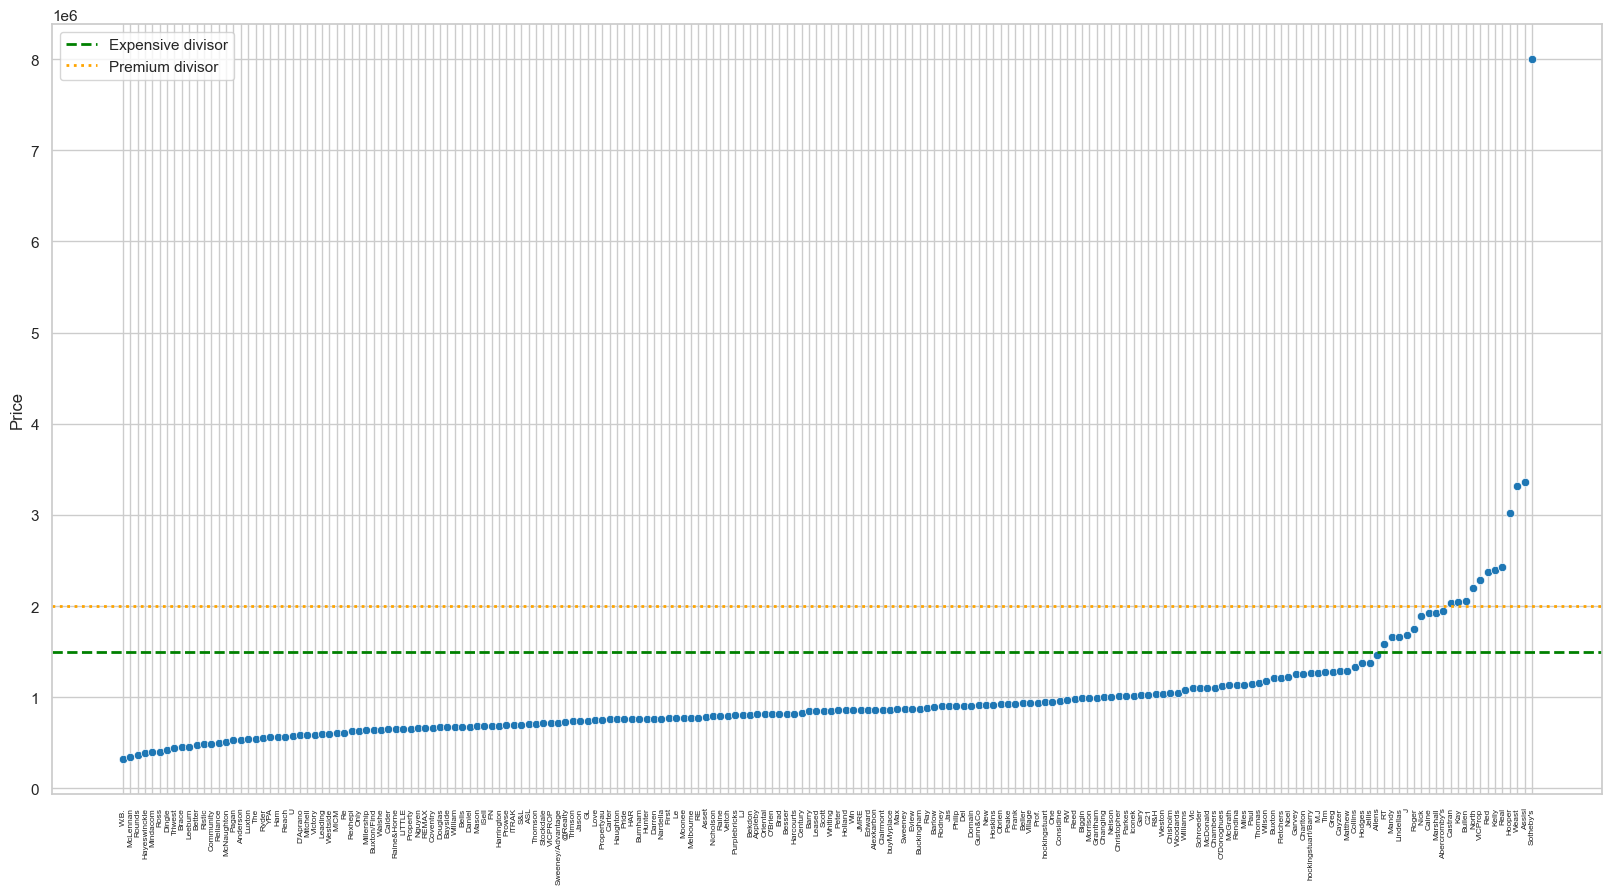

In [71]:
seller_pricing, _ = plot_distribution_grouped_field(train_set_processed, field='SellerG')

In [72]:
train_set_processed = classify_category(
    df=train_set_processed,
    group_pricing=seller_pricing,
    input_column_name='SellerG',
    output_column_name='seller_class',
    premium_threshold=2e6,
    expensive_threshold=1.5e6,
)

valid_set_processed = classify_category(
    df=valid_set_processed,
    group_pricing=seller_pricing,
    input_column_name='SellerG',
    output_column_name='seller_class',
    premium_threshold=2e6,
    expensive_threshold=1.5e6,
)

test_set_processed = classify_category(
    df=test_set_processed,
    group_pricing=seller_pricing,
    input_column_name='SellerG',
    output_column_name='seller_class',
    premium_threshold=2e6,
    expensive_threshold=1.5e6,
)

Moreover, instead of bucketizing we can create a value that ranges from 0-1 that tells you how much that suburb pricing is.

In [73]:
def get_scoring_mean_price(df: pd.DataFrame, column_grouped: str, price_column: str = 'Price'):
    df_means = pd.DataFrame(df\
        .groupby(column_grouped)\
        .mean()[price_column]\
        .sort_values())

    max_df_price_grouped = df_means[price_column].max()
    df_means['price_mean_proportion'] = df_means[price_column] / max_df_price_grouped
    
    return df_means

In [74]:
def get_scoring_median_price(df: pd.DataFrame, column_grouped: str, price_column: str = 'Price'):
    df_medians = pd.DataFrame(df\
        .groupby(column_grouped)\
        .median()[price_column]\
        .sort_values())

    max_df_price_grouped = df_medians[price_column].max()
    df_medians['price_median_proportion'] = df_medians[price_column] / max_df_price_grouped
    
    return df_medians

In [75]:
seller_mean = get_scoring_mean_price(train_set_processed, 'SellerG')
seller_median = get_scoring_median_price(train_set_processed, 'SellerG')

/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_58351/3235938526.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_means = pd.DataFrame(df\
/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_58351/3019867369.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_medians = pd.DataFrame(df\


<AxesSubplot:>

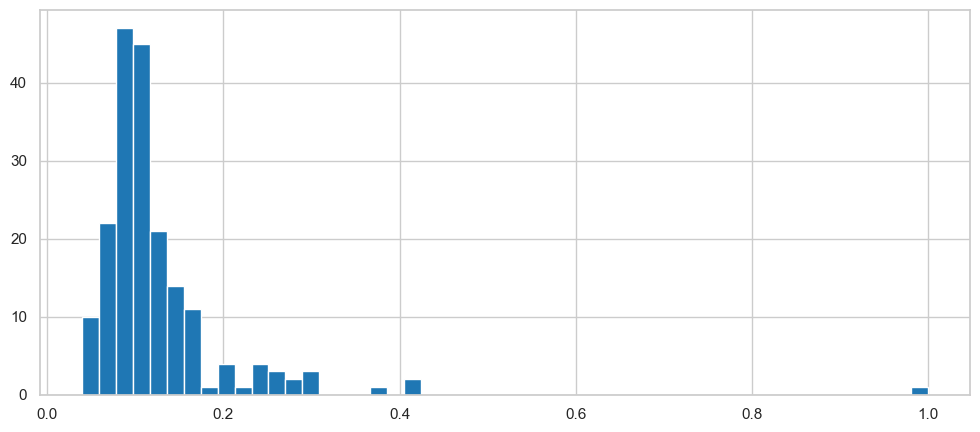

In [76]:
seller_mean.price_mean_proportion.hist(bins=50)

<AxesSubplot:>

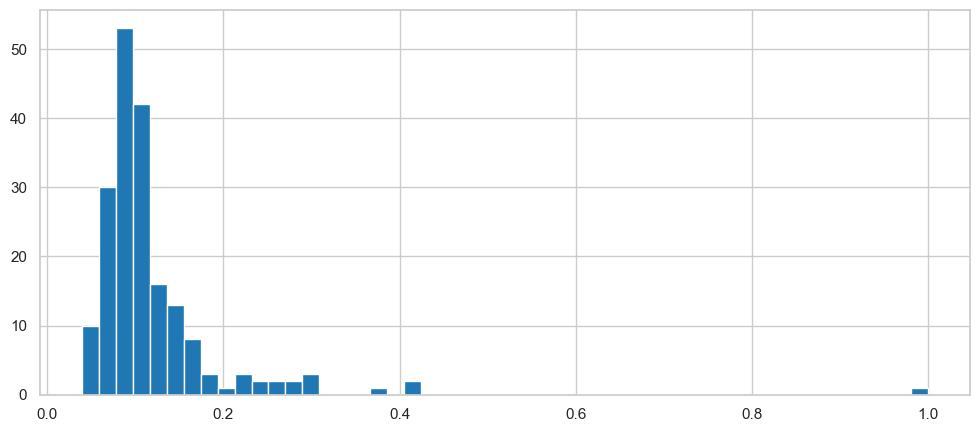

In [77]:
seller_median.price_median_proportion.hist(bins=50)

In [78]:
def set_price_proportions(
    df: pd.DataFrame, 
    df_price_mean: pd.DataFrame,
    target_column_df: str,
    suffix: str = '_price_mean_prop'
):
    # By default will be values of 0, in the case we have not seem some
    new_column = str(target_column_df + suffix).lower()
    df.loc[:, new_column] = .0
    
    for idx, row in df.iterrows():
        try:
            df.loc[idx, new_column] = df_price_mean.loc[row[target_column_df]].values[1]
        
        # In case some seller is not found
        except:
            df.loc[idx, new_column] = 0
            continue 
    
    return df

In [79]:
# And we place those values into the dataframe
train_set_processed = set_price_proportions(train_set_processed, seller_mean, 'SellerG')
valid_set_processed = set_price_proportions(valid_set_processed, seller_mean, 'SellerG')
test_set_processed = set_price_proportions(test_set_processed, seller_mean, 'SellerG')

In [80]:
train_set_processed = set_price_proportions(train_set_processed, seller_median, 'SellerG', '_price_median_prop')
valid_set_processed = set_price_proportions(valid_set_processed, seller_median, 'SellerG', '_price_median_prop')
test_set_processed = set_price_proportions(test_set_processed, seller_median, 'SellerG', '_price_median_prop')

### Suburb

/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_58351/2600807695.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_pricing = df\


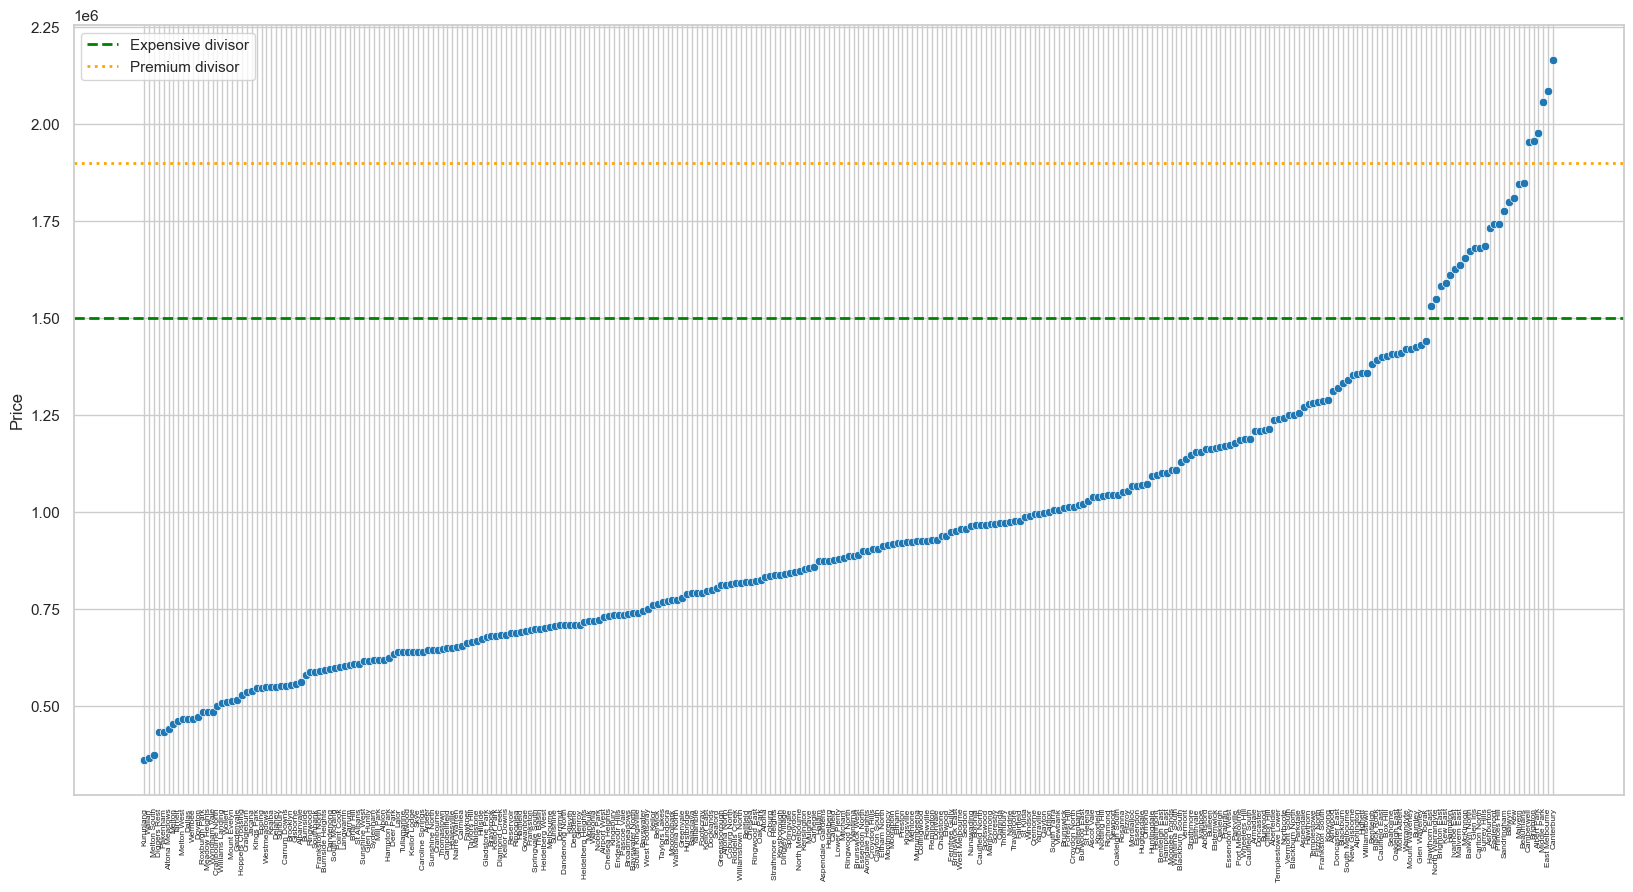

In [81]:
suburb_pricing, _ = plot_distribution_grouped_field(
    train_set_processed,
    field='Suburb', 
    expensive_divisor=1.5e6, 
    premium_divisor=1.9e6
)

In [82]:
train_set_processed = classify_category(
    df=train_set_processed,
    group_pricing=suburb_pricing,
    input_column_name='Suburb',
    output_column_name='suburb_class',
    premium_threshold=1.9e6,
    expensive_threshold=1.5e6,
)

valid_set_processed = classify_category(
    df=valid_set_processed,
    group_pricing=suburb_pricing,
    input_column_name='Suburb',
    output_column_name='suburb_class',
    premium_threshold=1.9e6,
    expensive_threshold=1.5e6,
)

test_set_processed = classify_category(
    df=test_set_processed,
    group_pricing=suburb_pricing,
    input_column_name='Suburb',
    output_column_name='suburb_class',
    premium_threshold=1.9e6,
    expensive_threshold=1.5e6,
)

In [83]:
suburb_mean = get_scoring_mean_price(train_set_processed, 'Suburb')
suburb_median = get_scoring_median_price(train_set_processed, 'Suburb')

/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_58351/3235938526.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_means = pd.DataFrame(df\
/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_58351/3019867369.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_medians = pd.DataFrame(df\


<AxesSubplot:>

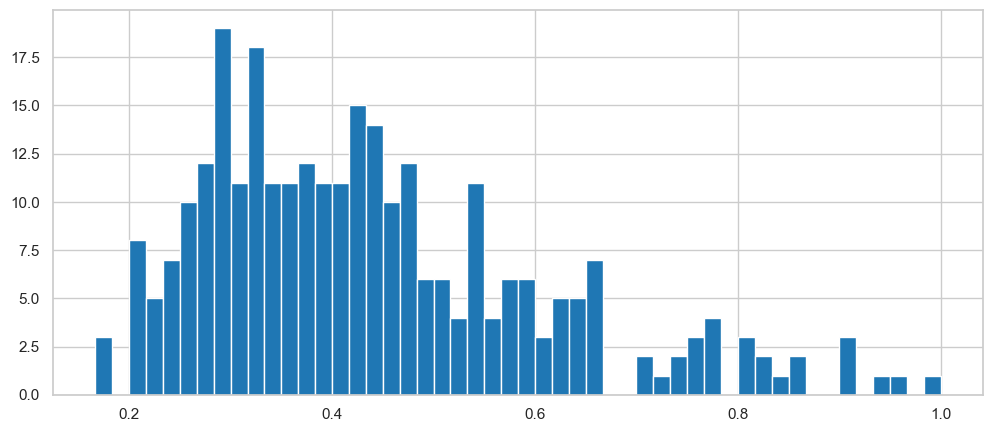

In [84]:
suburb_mean.price_mean_proportion.hist(bins=50)

In [85]:
train_set_processed = set_price_proportions(train_set_processed, suburb_mean, 'Suburb')
valid_set_processed = set_price_proportions(valid_set_processed, suburb_mean, 'Suburb')
test_set_processed = set_price_proportions(test_set_processed, suburb_mean, 'Suburb')

In [86]:
train_set_processed = set_price_proportions(train_set_processed, suburb_median, 'Suburb', '_price_median_prop')
valid_set_processed = set_price_proportions(valid_set_processed, suburb_median, 'Suburb', '_price_median_prop')
test_set_processed = set_price_proportions(test_set_processed, suburb_median, 'Suburb', '_price_median_prop')

### Council Area

/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_58351/2600807695.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_pricing = df\


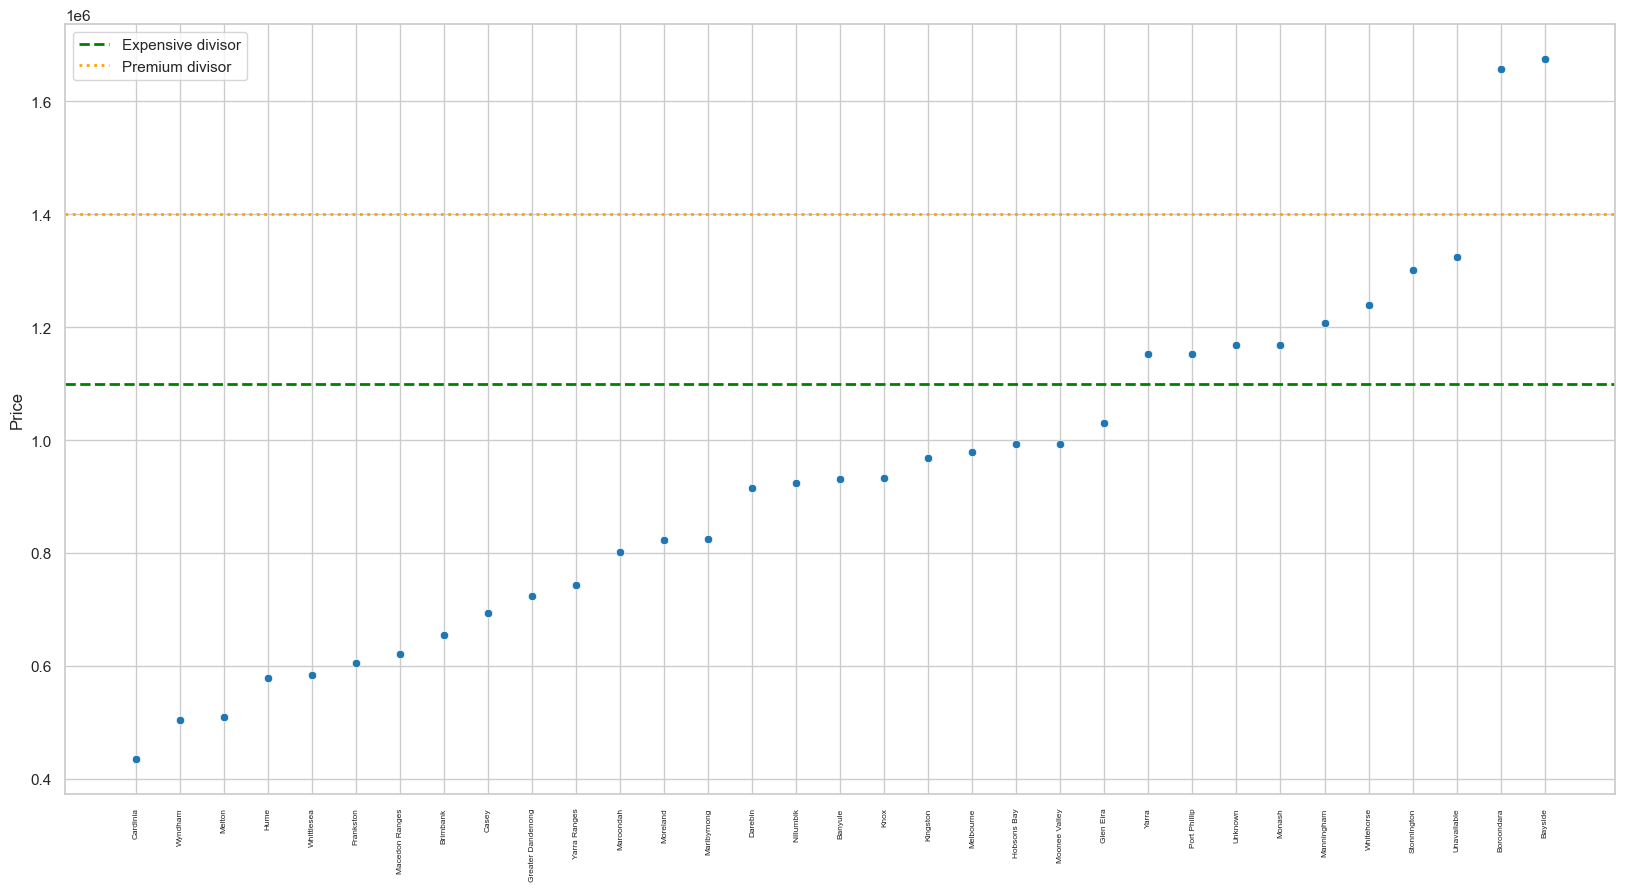

In [87]:
council_pricing, _ = plot_distribution_grouped_field(
    train_set_processed, 
    'CouncilArea', 
    expensive_divisor=1.1e6, 
    premium_divisor=1.4e6
)

In [88]:
train_set_processed = classify_category(
    df=train_set_processed,
    group_pricing=council_pricing,
    input_column_name='CouncilArea',
    output_column_name='council_class',
    premium_threshold=1e6,
    expensive_threshold=1.3e6,
)

valid_set_processed = classify_category(
    df=valid_set_processed,
    group_pricing=council_pricing,
    input_column_name='CouncilArea',
    output_column_name='council_class',
    premium_threshold=1e6,
    expensive_threshold=1.3e6,
)

test_set_processed = classify_category(
    df=test_set_processed,
    group_pricing=council_pricing,
    input_column_name='CouncilArea',
    output_column_name='council_class',
    premium_threshold=1e6,
    expensive_threshold=1.3e6,
)

/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_58351/3235938526.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_means = pd.DataFrame(df\
/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_58351/3019867369.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_medians = pd.DataFrame(df\


<AxesSubplot:>

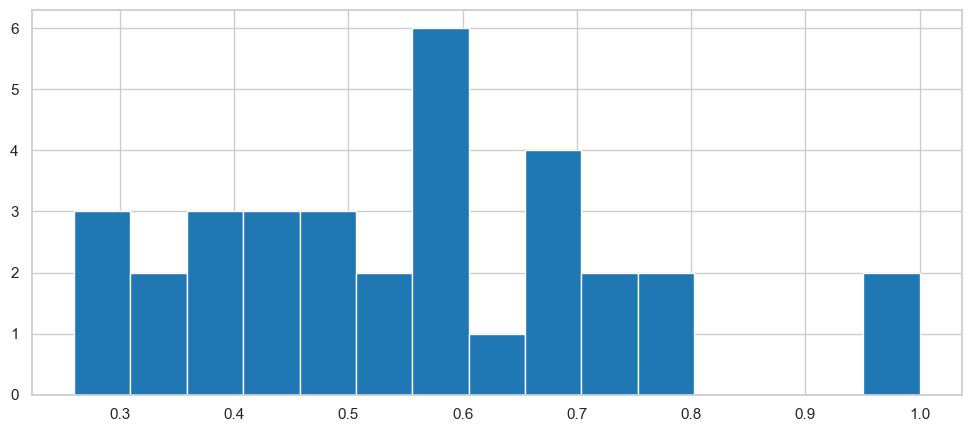

In [89]:
council_mean = get_scoring_mean_price(train_set_processed, 'CouncilArea')
council_median = get_scoring_median_price(train_set_processed, 'CouncilArea')
council_mean.price_mean_proportion.hist(bins=15)

In [90]:
train_set_processed = set_price_proportions(train_set_processed, council_mean, 'CouncilArea')
valid_set_processed = set_price_proportions(valid_set_processed, council_mean, 'CouncilArea')
test_set_processed = set_price_proportions(test_set_processed, council_mean, 'CouncilArea')

train_set_processed = set_price_proportions(train_set_processed, council_median, 'CouncilArea', '_price_median_prop')
valid_set_processed = set_price_proportions(valid_set_processed, council_median, 'CouncilArea', '_price_median_prop')
test_set_processed = set_price_proportions(test_set_processed, council_median, 'CouncilArea', '_price_median_prop')

### Address

There are a lof of different addresses.
We could check for the case of some has been re-sold.

In [91]:
def add_feature_resold(
    data_duplicated: pd.DataFrame, 
    data_source: pd.DataFrame
):
    
    before, actual = '', ''
    for idx, row in data_duplicated.iterrows():
        if not before:
            before = row['Address']
            data_source.loc[idx, 'Resold'] = 0
            continue

        actual = row['Address']
        if before == actual:
            # Set it directly this new feature on extended dataframe
            data_source.loc[idx, 'Resold'] = 1

        else:
            data_source.loc[idx, 'Resold'] = 0
            before = actual
    
    return data_source

def check_resold_houses(data: pd.DataFrame):
    # Will assume that the ones with same values in address, room, bedroom and bathroom is the same house being sold
    multiple_sold = data[
        data.duplicated(
            subset=['Address', 'Rooms', 'Bedroom2', 'Bathroom'], 
            keep=False
        )
    ].sort_values(['Address', 'Date'])
    
    # And now we add the feature of being sold
    if len(multiple_sold) > 0:
        data = add_feature_resold(multiple_sold, data)
        data['Resold'] = data['Resold'].fillna(0).astype('int8')
    else:
        data['Resold'] = 0
    
    # An example with the ones sold more than once
    display(data.loc[multiple_sold.index].head(2))
    
    address_feature = ['Resold']
    
    return data, address_feature

In [ ]:
train_set_processed, _ = check_resold_houses(train_set_processed)
valid_set_processed, _ = check_resold_houses(valid_set_processed)
test_set_processed, _ = check_resold_houses(test_set_processed)

In [93]:
train_set_processed.drop(['Address'], axis=1, inplace=True)
valid_set_processed.drop(['Address'], axis=1, inplace=True)
test_set_processed.drop(['Address'], axis=1, inplace=True)

### Type, Regionname & Method

Simply creating one-hot encoding for them.

In [94]:
train_set_processed = pd.get_dummies(
    train_set_processed, 
    columns=['Method'], 
    drop_first=True
)

valid_set_processed = pd.get_dummies(
    valid_set_processed, 
    columns=['Method'], 
    drop_first=True
)

test_set_processed = pd.get_dummies(
    test_set_processed, 
    columns=['Method'], 
    drop_first=True
)

In [95]:
train_set_processed = pd.get_dummies(
    train_set_processed, 
    columns=['Type'], 
    drop_first=True
)

valid_set_processed = pd.get_dummies(
    valid_set_processed, 
    columns=['Type'], 
    drop_first=True
)

test_set_processed = pd.get_dummies(
    test_set_processed, 
    columns=['Type'], 
    drop_first=True
)

In [96]:
train_set_processed = pd.get_dummies(
    train_set_processed, 
    columns=['Regionname'], 
    drop_first=True
)

valid_set_processed = pd.get_dummies(
    valid_set_processed, 
    columns=['Regionname'], 
    drop_first=True
)

test_set_processed = pd.get_dummies(
    test_set_processed, 
    columns=['Regionname'], 
    drop_first=True
)

### Postcode & Date

Postcode is a categorical variable, as the numbers does not have an order. So we will remove that one.

For date, we will extract the date in which it was sold and the difference.

In [98]:
# Dropping postcodes
train_set_processed.drop(['Postcode'], axis=1, inplace=True)
valid_set_processed.drop(['Postcode'], axis=1, inplace=True)
test_set_processed.drop(['Postcode'], axis=1, inplace=True)

In [99]:
train_set_processed['Date'] = pd.to_datetime(train_set_processed['Date'])
valid_set_processed['Date'] = pd.to_datetime(valid_set_processed['Date'])
test_set_processed['Date'] = pd.to_datetime(test_set_processed['Date'])

train_set_processed['year_sold'] = train_set_processed['Date'].dt.year
valid_set_processed['year_sold'] = valid_set_processed['Date'].dt.year
test_set_processed['year_sold'] = test_set_processed['Date'].dt.year

train_set_processed['quarter_sold'] = train_set_processed.Date.dt.quarter
valid_set_processed['quarter_sold'] = valid_set_processed.Date.dt.quarter
test_set_processed['quarter_sold'] = test_set_processed.Date.dt.quarter

In [100]:
train_set_processed['years_to_sell'] = train_set_processed['year_sold'] - train_set_processed['YearBuilt']
valid_set_processed['years_to_sell'] = valid_set_processed['year_sold'] - valid_set_processed['YearBuilt']
test_set_processed['years_to_sell'] = test_set_processed['year_sold'] - test_set_processed['YearBuilt']

In [101]:
# Dropping date
train_set_processed.drop(['Date'], axis=1, inplace=True)
valid_set_processed.drop(['Date'], axis=1, inplace=True)
test_set_processed.drop(['Date'], axis=1, inplace=True)

# Feature Engineering

Apart from the features we already created, we are going to add some more.

In [102]:
train_set_extended = train_set_processed.copy()
valid_set_extended = valid_set_processed.copy()
test_set_extended = test_set_processed.copy()

### Ratios

In [104]:
# Adding ratios
train_set_extended['bed_bath_ratio'] = train_set_extended['Bedroom2'] + 1 / train_set_extended['Bathroom'] + 1
train_set_extended['car_bed_ratio'] = train_set_extended['Car'] + 1/ train_set_extended['Bedroom2'] + 1
train_set_extended['bed_room_ratio'] = train_set_extended['Bedroom2'] + 1 / train_set_extended['Rooms'] + 1
train_set_extended['bath_room_ratio'] = train_set_extended['Bathroom'] + 1 / train_set_extended['Rooms'] + 1
train_set_extended['room_building_area_ratio'] = train_set_extended['Rooms'] + 1 / train_set_extended['BuildingArea'] + 1
train_set_extended['bed_building_area_ratio'] = train_set_extended['Bedroom2'] + 1 / train_set_extended['BuildingArea'] + 1
train_set_extended['bath_building_area_ratio'] = train_set_extended['Bathroom'] + 1 / train_set_extended['BuildingArea'] + 1


valid_set_extended['bed_bath_ratio'] = valid_set_extended['Bedroom2'] + 1 / valid_set_extended['Bathroom'] + 1
valid_set_extended['car_bed_ratio'] = valid_set_extended['Car'] + 1/ valid_set_extended['Bedroom2'] + 1
valid_set_extended['bed_room_ratio'] = valid_set_extended['Bedroom2'] + 1 / valid_set_extended['Rooms'] + 1
valid_set_extended['bath_room_ratio'] = valid_set_extended['Bathroom'] + 1 / valid_set_extended['Rooms'] + 1
valid_set_extended['room_building_area_ratio'] = valid_set_extended['Rooms'] + 1 / valid_set_extended['BuildingArea'] + 1
valid_set_extended['bed_building_area_ratio'] = valid_set_extended['Bedroom2'] + 1 / valid_set_extended['BuildingArea'] + 1
valid_set_extended['bath_building_area_ratio'] = valid_set_extended['Bathroom'] + 1 / valid_set_extended['BuildingArea'] + 1


test_set_extended['bed_bath_ratio'] = test_set_extended['Bedroom2'] + 1 / test_set_extended['Bathroom'] + 1
test_set_extended['car_bed_ratio'] = test_set_extended['Car'] + 1/ test_set_extended['Bedroom2'] + 1
test_set_extended['bed_room_ratio'] = test_set_extended['Bedroom2'] + 1 / test_set_extended['Rooms'] + 1
test_set_extended['bath_room_ratio'] = test_set_extended['Bathroom'] + 1 / test_set_extended['Rooms'] + 1
test_set_extended['room_building_area_ratio'] = test_set_extended['Rooms'] + 1 / test_set_extended['BuildingArea'] + 1
test_set_extended['bed_building_area_ratio'] = test_set_extended['Bedroom2'] + 1 / test_set_extended['BuildingArea'] + 1
test_set_extended['bath_building_area_ratio'] = test_set_extended['Bathroom'] + 1 / test_set_extended['BuildingArea'] + 1

### Logs & Sqrt

In [105]:
# Adding the logarithms
train_set_extended = create_logs(train_set_extended)
valid_set_extended = create_logs(valid_set_extended)
test_set_extended = create_logs(test_set_extended)

In [106]:
train_set_extended['Price_log'] = np.log(train_set_extended.Price + 1)
valid_set_extended['Price_log'] = np.log(valid_set_extended.Price + 1)

In [ ]:
suburb_means_log = get_scoring_mean_price(train_set_extended, 'Suburb', 'Price_log')
suburb_median_log = get_scoring_median_price(train_set_extended, 'Suburb', 'Price_log')

train_set_extended = set_price_proportions(train_set_extended, suburb_means_log, 'Suburb', '_price_mean_log_prop')
train_set_extended = set_price_proportions(train_set_extended, suburb_median_log, 'Suburb', '_price_median_log_prop')
valid_set_extended = set_price_proportions(valid_set_extended, suburb_means_log, 'Suburb', '_price_mean_log_prop')
valid_set_extended = set_price_proportions(valid_set_extended, suburb_median_log, 'Suburb', '_price_median_log_prop')
test_set_extended = set_price_proportions(test_set_extended, suburb_means_log, 'Suburb', '_price_mean_log_prop')
test_set_extended = set_price_proportions(test_set_extended, suburb_median_log, 'Suburb', '_price_median_log_prop')

council_area_means_log = get_scoring_mean_price(train_set_extended, 'CouncilArea', 'Price_log')
council_area_median_log = get_scoring_median_price(train_set_extended, 'CouncilArea', 'Price_log')

train_set_extended = set_price_proportions(train_set_extended, council_area_means_log, 'CouncilArea', '_price_mean_log_prop')
train_set_extended = set_price_proportions(train_set_extended, council_area_median_log, 'CouncilArea', '_price_median_log_prop')
valid_set_extended = set_price_proportions(valid_set_extended, council_area_means_log, 'CouncilArea', '_price_mean_log_prop')
valid_set_extended = set_price_proportions(valid_set_extended, council_area_median_log, 'CouncilArea', '_price_median_log_prop')
test_set_extended = set_price_proportions(test_set_extended, council_area_means_log, 'CouncilArea', '_price_mean_log_prop')
test_set_extended = set_price_proportions(test_set_extended, council_area_median_log, 'CouncilArea', '_price_median_log_prop')

seller_means_log = get_scoring_mean_price(train_set_processed, 'SellerG', 'Price_log')
seller_median_log = get_scoring_median_price(train_set_processed, 'SellerG', 'Price_log')

train_set_extended = set_price_proportions(train_set_extended, seller_means_log, 'SellerG', '_price_mean_log_prop')
train_set_extended = set_price_proportions(train_set_extended, seller_median_log, 'SellerG', '_price_median_log_prop')
valid_set_extended = set_price_proportions(valid_set_extended, seller_means_log, 'SellerG', '_price_mean_log_prop')
valid_set_extended = set_price_proportions(valid_set_extended, seller_median_log, 'SellerG', '_price_median_log_prop')
test_set_extended = set_price_proportions(test_set_extended, seller_means_log, 'SellerG', '_price_mean_log_prop')
test_set_extended = set_price_proportions(test_set_extended, seller_median_log, 'SellerG', '_price_median_log_prop')

In [108]:
test_set_extended = set_price_proportions(test_set_extended, suburb_means_log, 'Suburb', '_price_mean_log_prop')


In [109]:
# And remove the SellerG that will no longer be used
to_drop = ['SellerG', 'Suburb', 'CouncilArea']

for col in to_drop:
    train_set_extended.drop([col], axis=1, inplace=True)
    valid_set_extended.drop([col], axis=1, inplace=True)
    test_set_extended.drop([col], axis=1, inplace=True)

In [110]:
train_set_extended['Distance_sqr'] = np.sqrt(train_set_extended['Distance'])
train_set_extended['Landsize_sqr'] = np.sqrt(train_set_extended['Landsize'])
train_set_extended['BuildingArea_sqr'] = np.sqrt(train_set_extended['BuildingArea'])
train_set_extended['Propertycount_sqr'] = np.sqrt(train_set_extended['Propertycount'])

valid_set_extended['Distance_sqr'] = np.sqrt(valid_set_extended['Distance'])
valid_set_extended['Landsize_sqr'] = np.sqrt(valid_set_extended['Landsize'])
valid_set_extended['BuildingArea_sqr'] = np.sqrt(valid_set_extended['BuildingArea'])
valid_set_extended['Propertycount_sqr'] = np.sqrt(valid_set_extended['Propertycount'])

test_set_extended['Distance_sqr'] = np.sqrt(test_set_extended['Distance'])
test_set_extended['Landsize_sqr'] = np.sqrt(test_set_extended['Landsize'])
test_set_extended['BuildingArea_sqr'] = np.sqrt(test_set_extended['BuildingArea'])
test_set_extended['Propertycount_sqr'] = np.sqrt(test_set_extended['Propertycount'])

### Property Count

Will bucketize also this feature.

In [111]:
# Create buckets of property count
_, pc_bins = pd.qcut(train_set_extended['Propertycount'], 9, labels=False, retbins=True)

train_set_extended['prop_count_bkt'] = pd.cut(
    train_set_extended['Propertycount'], 
    bins=pc_bins, 
    labels=range(len(pc_bins)-1),
    include_lowest=True
)

valid_set_extended['prop_count_bkt'] = pd.cut(
    valid_set_extended['Propertycount'], 
    bins=pc_bins, 
    labels=range(len(pc_bins)-1),
    include_lowest=True
)

test_set_extended['prop_count_bkt'] = pd.cut(
    test_set_extended['Propertycount'], 
    bins=pc_bins, 
    labels=range(len(pc_bins)-1),
    include_lowest=True
)
test_set_extended['prop_count_bkt'].fillna(0.0, inplace=True) # one of 250

In [112]:
train_set_extended['prop_count_bkt'] = train_set_extended['prop_count_bkt'].astype('int8')
valid_set_extended['prop_count_bkt'] = valid_set_extended['prop_count_bkt'].astype('int8')
test_set_extended['prop_count_bkt'] = test_set_extended['prop_count_bkt'].astype('int8')

In [113]:
# Could be a good ratio the price / property count, as might be the ones with more allocation the cheaper
prop_count_bkt_mean = get_scoring_mean_price(train_set_extended, 'prop_count_bkt')
prop_count_bkt_median = get_scoring_median_price(train_set_extended, 'prop_count_bkt')

prop_count_bkt_mean_log = get_scoring_mean_price(train_set_extended, 'prop_count_bkt', 'Price_log')
prop_count_bkt_median_log = get_scoring_median_price(train_set_extended, 'prop_count_bkt', 'Price_log')

In [114]:
train_set_extended = set_price_proportions(train_set_extended, prop_count_bkt_mean, 'prop_count_bkt', '_price_mean_prop')
valid_set_extended = set_price_proportions(valid_set_extended, prop_count_bkt_mean, 'prop_count_bkt', '_price_mean_prop')
test_set_extended = set_price_proportions(test_set_extended, prop_count_bkt_mean, 'prop_count_bkt', '_price_mean_prop')

train_set_extended = set_price_proportions(train_set_extended, prop_count_bkt_median, 'prop_count_bkt', '_price_median_prop')
valid_set_extended = set_price_proportions(valid_set_extended, prop_count_bkt_median, 'prop_count_bkt', '_price_median_prop')
test_set_extended = set_price_proportions(test_set_extended, prop_count_bkt_median, 'prop_count_bkt', '_price_median_prop')

train_set_extended = set_price_proportions(train_set_extended, prop_count_bkt_mean_log, 'prop_count_bkt', '_price_mean_log_prop')
valid_set_extended = set_price_proportions(valid_set_extended, prop_count_bkt_mean_log, 'prop_count_bkt', '_price_mean_log_prop')
test_set_extended = set_price_proportions(test_set_extended, prop_count_bkt_mean_log, 'prop_count_bkt', '_price_mean_log_prop')

train_set_extended = set_price_proportions(train_set_extended, prop_count_bkt_median_log, 'prop_count_bkt', '_price_median_log_prop')
valid_set_extended = set_price_proportions(valid_set_extended, prop_count_bkt_median_log, 'prop_count_bkt', '_price_median_log_prop')
test_set_extended = set_price_proportions(test_set_extended, prop_count_bkt_median_log, 'prop_count_bkt', '_price_median_log_prop')

### Longtitude & Lattitude

Will assume that there are groups for that location that are of relevent importance for the price.

In [115]:
train_long_lat = train_set_extended[['Longtitude', 'Lattitude']]
valid_long_lat = valid_set_extended[['Longtitude', 'Lattitude']]
test_long_lat = test_set_extended[['Longtitude', 'Lattitude']]

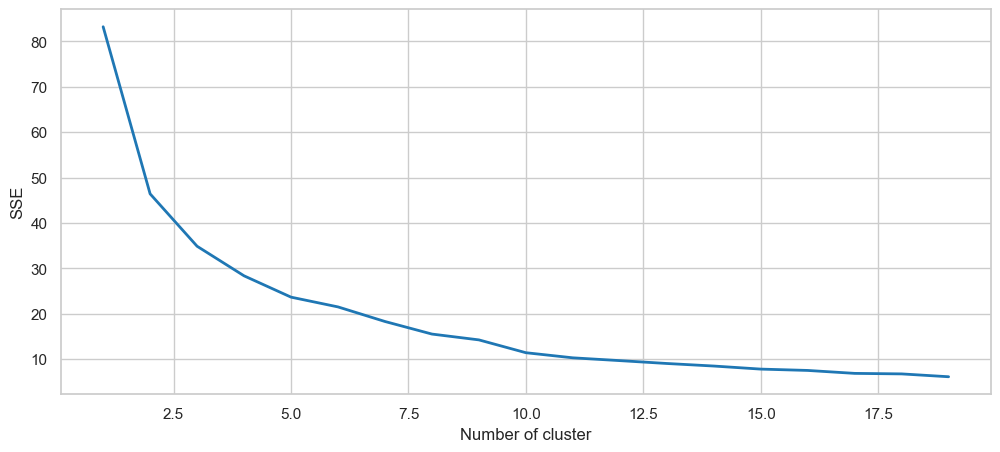

In [116]:
sse = {}
for k in range(1, 20):
    kmeans = KMeans(
        n_clusters=k, 
        max_iter=1000, 
        n_init='auto'
    ).fit(train_long_lat)
        
    # Squarred Sum of Errors
    sse[k] = kmeans.inertia_
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [117]:
divisor = 12
n_features = math.floor((train_set['YearBuilt'].nunique() / divisor))

print('Number of features: ', n_features)
k_means = KMeans(
    n_clusters=n_features, 
    n_init='auto',
    max_iter=1000
)

k_means.fit(train_long_lat)

Number of features:  9


KMeans(max_iter=1000, n_clusters=9, n_init='auto')

In [118]:
# With the same model trained we predict both groups for test & trian
labels_train = k_means.labels_
labels_valid = k_means.predict(valid_long_lat)
labels_test = k_means.predict(test_long_lat)

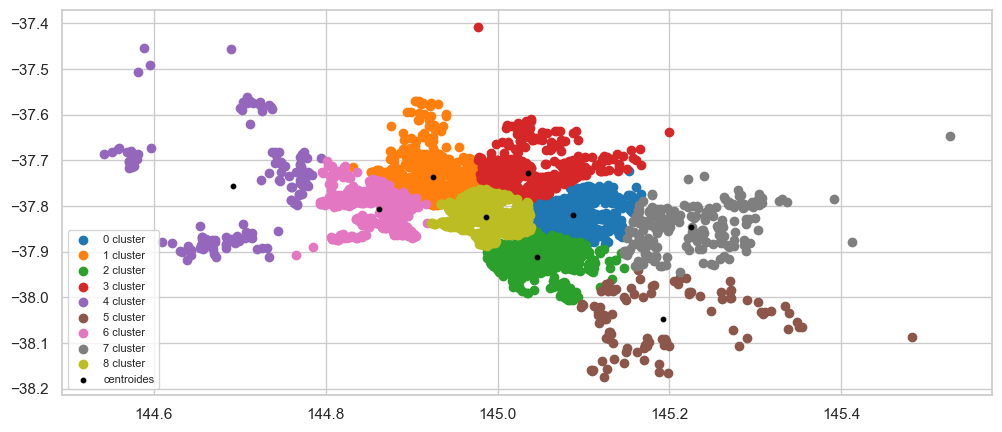

In [119]:
centroides = k_means.cluster_centers_
etiquetas = k_means.labels_

unique_labels = np.unique(labels_train)
 
for label in unique_labels:
    plt.scatter(
        train_long_lat.iloc[labels_train == label, 0], 
        train_long_lat.iloc[labels_train == label, 1], 
        label = f"{label} cluster",
    )

plt.scatter(
    centroides[:,0],
    centroides[:,1], 
    label='centroides', 
    color = 'k', 
    s=10
)

plt.legend(
    prop={'size': 8}
)
plt.show()

In [120]:
# Add this new feature into the dataframe
train_set_extended['location_group'] = labels_train
valid_set_extended['location_group'] = labels_valid
test_set_extended['location_group'] = labels_test

In [124]:
# train_set_extended['location_group'] = train_set_extended['location_group'].astype('category')
# valid_set_extended['location_group'] = valid_set_extended['location_group'].astype('category')
# test_set_extended['location_group'] = test_set_extended['location_group'].astype('category')

Having those clusters identified can be interesting for then to see distribution of the prices in each one. And letting a model to have a value for which to pivot -/+ with respect to make the prediction.

Will also create another cluster for the ones that have price in the 95th percentile or more

For now, for each of the known clusters we will impute which is the mean/median in each of their locations, and divide by the max in each of their respective locations.

In [121]:
location_group_info = train_set_extended\
    .groupby('location_group')[['Price', 'Price_log']]\
    .describe().T

location_group_info

location_group              0             1             2             3  \
Price     count  6.100000e+02  7.960000e+02  7.010000e+02  6.030000e+02   
          mean   1.562151e+06  8.816819e+05  1.298382e+06  8.717095e+05   
          std    8.062118e+05  3.924458e+05  6.959741e+05  4.131423e+05   
          min    2.920000e+05  1.450000e+05  2.565000e+05  2.450000e+05   
          25%    1.001250e+06  6.050000e+05  8.280000e+05  6.202500e+05   
          50%    1.462000e+06  8.195000e+05  1.200000e+06  7.900000e+05   
          75%    1.900000e+06  1.075250e+06  1.620000e+06  1.004000e+06   
          max    8.000000e+06  3.400000e+06  5.500000e+06  2.850000e+06   
Price_log count  6.100000e+02  7.960000e+02  7.010000e+02  6.030000e+02   
          mean   1.413612e+01  1.359528e+01  1.393914e+01  1.358527e+01   
          std    5.137621e-01  4.402421e-01  5.394019e-01  4.233680e-01   
          min    1.258451e+01  1.188450e+01  1.245489e+01  1.240902e+01   
          25%    1.381676e+01  1.331299e+01  1.362677e+01  1.333788e+01   
          50%    1.419532e+01  1.361645e+01  1.399783e+01  1.357979e+01   
          75%    1.445736e+01  1.388806e+01  1.429794e+01  1.381950e+01   
          max    1.589495e+01  1.503929e+01  1.552026e+01  1.486283e+01   

location_group              4             5             6             7  \
Price     count  1.350000e+02  9.600000e+01  5.850000e+02  1.900000e+02   
          mean   5.514585e+05  7.647553e+05  8.410326e+05  1.000844e+06   
          std    1.633197e+05  2.685073e+05  3.439722e+05  3.486177e+05   
          min    3.000000e+05  3.480000e+05  1.850000e+05  4.500000e+05   
          25%    4.422500e+05  6.088750e+05  6.225000e+05  7.655000e+05   
          50%    5.260000e+05  6.915000e+05  7.810000e+05  9.160000e+05   
          75%    6.191750e+05  8.720000e+05  9.600000e+05  1.183500e+06   
          max    1.355000e+06  1.905000e+06  2.910000e+06  3.056000e+06   
Price_log count  1.350000e+02  9.600000e+01  5.850000e+02  1.900000e+02   
          mean   1.318404e+01  1.349710e+01  1.356768e+01  1.376384e+01   
          std    2.624760e-01  3.083492e-01  3.867963e-01  3.192646e-01   
          min    1.261154e+01  1.275996e+01  1.212812e+01  1.301701e+01   
          25%    1.299963e+01  1.331937e+01  1.334150e+01  1.354828e+01   
          50%    1.317306e+01  1.344661e+01  1.356833e+01  1.372776e+01   
          75%    1.333614e+01  1.367854e+01  1.377469e+01  1.398399e+01   
          max    1.411931e+01  1.445999e+01  1.488366e+01  1.493262e+01   

location_group              8  
Price     count  9.010000e+02  
          mean   1.175044e+06  
          std    7.730460e+05  
          min    1.600000e+05  
          25%    6.120000e+05  
          50%    1.000000e+06  
          75%    1.475000e+06  
          max    5.700000e+06  
Price_log count  9.010000e+02  
          mean   1.379736e+01  
          std    5.948911e-01  
          min    1.198294e+01  
          25%    1.332449e+01  
          50%    1.381551e+01  
          75%    1.420417e+01  
          max    1.555598e+01

In [122]:
location_means = get_scoring_mean_price(train_set_extended, 'location_group')
location_median = get_scoring_median_price(train_set_extended, 'location_group')

location_means_log = get_scoring_mean_price(train_set_extended, 'location_group', 'Price_log')
location_median_log = get_scoring_median_price(train_set_extended, 'location_group', 'Price_log')

In [123]:
train_set_extended = set_price_proportions(train_set_extended, location_means, 'location_group', '_price_mean_prop')
valid_set_extended = set_price_proportions(valid_set_extended, location_means, 'location_group', '_price_mean_prop')
test_set_extended = set_price_proportions(test_set_extended, location_means, 'location_group', '_price_mean_prop')

train_set_extended = set_price_proportions(train_set_extended, location_median, 'location_group', '_price_median_prop')
valid_set_extended = set_price_proportions(valid_set_extended, location_median, 'location_group', '_price_median_prop')
test_set_extended = set_price_proportions(test_set_extended, location_median, 'location_group', '_price_median_prop')

train_set_extended = set_price_proportions(train_set_extended, location_means_log, 'location_group', '_price_mean_log_prop')
valid_set_extended = set_price_proportions(valid_set_extended, location_means_log, 'location_group', '_price_mean_log_prop')
test_set_extended = set_price_proportions(test_set_extended, location_means_log, 'location_group', '_price_mean_log_prop')

train_set_extended = set_price_proportions(train_set_extended, location_median_log, 'location_group', '_price_median_log_prop')
valid_set_extended = set_price_proportions(valid_set_extended, location_median_log, 'location_group', '_price_median_log_prop')
test_set_extended = set_price_proportions(test_set_extended, location_median_log, 'location_group', '_price_median_log_prop')

### Sum Up of Variables

In [128]:
print(train_set_extended.dtypes.to_string())

Rooms                                      int64
Price                                    float64
Distance                                 float64
Bedroom2                                 float64
Bathroom                                 float64
Car                                      float64
Landsize                                 float64
BuildingArea                             float64
YearBuilt                                float64
Lattitude                                float64
Longtitude                               float64
Propertycount                            float64
Price_log                                float64
seller_class                             float64
sellerg_price_mean_prop                  float64
sellerg_price_median_prop                float64
suburb_class                             float64
suburb_price_mean_prop                   float64
suburb_price_median_prop                 float64
council_class                            float64
councilarea_price_me

In [124]:
train_set_extended.isin([-np.inf, np.inf]).sum().sum()

0

# Model Creation: Price Log

In [125]:
train_set_final_log = train_set_extended.copy()
valid_set_final_log = valid_set_extended.copy()
test_set_final_log = test_set_extended.copy()

In [126]:
pd.set_option('display.max_rows', 500)

corr_final_log = train_set_final_log.corr().sort_values('Price')[['Price', 'Price_log']]
corr_final_log

,Price,Price_log
Type_u,-0.386761,-0.506826
Lattitude,-0.204988,-0.216350
YearBuilt_log,-0.194843,-0.215503
YearBuilt,-0.193477,-0.214092
Regionname_Western Metropolitan,-0.176281,-0.167577
Distance,-0.174566,-0.167657
Regionname_Northern Metropolitan,-0.162253,-0.155691
Distance_sqr,-0.162167,-0.150693
location_group,-0.104400,-0.113821
Method_SP,-0.090896,-0.097690


<AxesSubplot:>

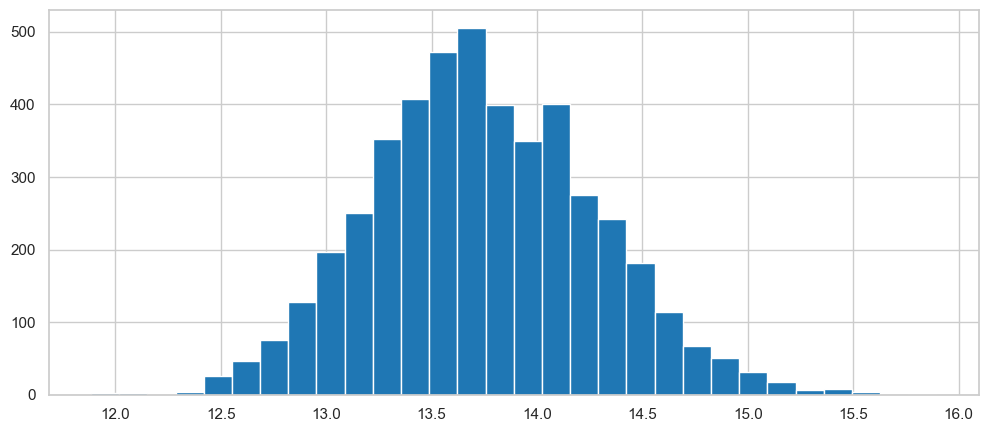

In [132]:
# More like a normal distribution
train_set_final_log.Price_log.hist(bins=30)

So we can see it could be easier to predict which is the logarithm of the price, and then afterwards we make the change.

In [127]:
# Extract features with corr > 10
final_features = corr_final_log[(corr_final_log.Price_log > .1) | (corr_final_log.Price_log < -.1)].index.values
final_features = [feature for feature in final_features if feature not in ['Price', 'Price_log']]
final_features

['Type_u',
 'Lattitude',
 'YearBuilt_log',
 'YearBuilt',
 'Regionname_Western Metropolitan',
 'Distance',
 'Regionname_Northern Metropolitan',
 'Distance_sqr',
 'location_group',
 'Regionname_Other',
 'Landsize_sqr',
 'Landsize_log',
 'prop_count_bkt_price_median_prop',
 'prop_count_bkt_price_median_log_prop',
 'years_to_sell',
 'prop_count_bkt_price_mean_log_prop',
 'Longtitude',
 'prop_count_bkt_price_mean_prop',
 'Regionname_Southern Metropolitan',
 'council_class',
 'BuildingArea_sqr',
 'bed_bath_ratio',
 'bath_room_ratio',
 'seller_class',
 'location_group_price_median_prop',
 'location_group_price_mean_log_prop',
 'location_group_price_median_log_prop',
 'location_group_price_mean_prop',
 'councilarea_price_median_prop',
 'councilarea_price_median_log_prop',
 'councilarea_price_mean_log_prop',
 'councilarea_price_mean_prop',
 'bed_room_ratio',
 'Bathroom_log',
 'Bedroom2_log',
 'bed_building_area_ratio',
 'Bedroom2',
 'bath_building_area_ratio',
 'Bathroom',
 'suburb_class',
 'Bu

In [128]:
# Will add categorical that were not considered before
final_features += ['prop_count_bkt', 'location_group']

In [129]:
# We will standarize those features
final_scaler = StandardScaler()

Y_train_set_final_log = train_set_final_log.Price_log.ravel().reshape(-1, 1)
X_train_set_final_log = train_set_final_log[final_features]

Y_valid_set_final_log = valid_set_final_log.Price_log.ravel().reshape(-1, 1)
X_valid_set_final_log = valid_set_final_log[final_features]

X_test_set_final_log = test_set_final_log[final_features]

X_train_set_final_log = final_scaler.fit_transform(X_train_set_final_log)
X_valid_set_final_log = final_scaler.transform(X_valid_set_final_log)
X_test_set_final_log = final_scaler.transform(X_test_set_final_log)

In [ ]:
test_set_final_log.head(3)

As requested in the problem, use LR or KNNeighbors.

### Linear Regressor

Can try different linear models.

In [130]:
lr_final_log_model = LinearRegression().fit(X_train_set_final_log, Y_train_set_final_log)

lr_pred = np.exp(lr_final_log_model.predict(X_valid_set_final_log))
print('Mean Squarred Error', mean_squared_error(lr_pred, np.exp(Y_valid_set_final_log), squared=False))
print('Mean Absolute Error', mean_absolute_error(lr_pred, np.exp(Y_valid_set_final_log)))
print('R2 Score', r2_score(lr_pred, np.exp(Y_valid_set_final_log)))

Mean Squarred Error 344305.87110399036
Mean Absolute Error 212082.4464272711
R2 Score 0.571645355813701


In [131]:
lr_final_log_model = HuberRegressor().fit(X_train_set_final_log, Y_train_set_final_log)

lr_pred = np.exp(lr_final_log_model.predict(X_valid_set_final_log))
print('Mean Squarred Error', mean_squared_error(lr_pred, np.exp(Y_valid_set_final_log), squared=False))
print('Mean Absolute Error', mean_absolute_error(lr_pred, np.exp(Y_valid_set_final_log)))
print('R2 Score', r2_score(lr_pred, np.exp(Y_valid_set_final_log)))

Mean Squarred Error 354060.8507518114
Mean Absolute Error 217059.8117698932
R2 Score 0.5433421732937658


In [132]:
lr_final_log_model = Lasso().fit(X_train_set_final_log, Y_train_set_final_log)

lr_pred = np.exp(lr_final_log_model.predict(X_valid_set_final_log))
print('Mean Squarred Error', mean_squared_error(lr_pred, np.exp(Y_valid_set_final_log), squared=False))
print('Mean Absolute Error', mean_absolute_error(lr_pred, np.exp(Y_valid_set_final_log)))
print('R2 Score', r2_score(lr_pred, np.exp(Y_valid_set_final_log)))

Mean Squarred Error 671963.9281439251
Mean Absolute Error 443622.2970192152
R2 Score -3.701937862681346e+30


In [133]:
lr_final_log_model = Ridge().fit(X_train_set_final_log, Y_train_set_final_log)

lr_pred = np.exp(lr_final_log_model.predict(X_valid_set_final_log))
print('Mean Squarred Error', mean_squared_error(lr_pred, np.exp(Y_valid_set_final_log), squared=False))
print('Mean Absolute Error', mean_absolute_error(lr_pred, np.exp(Y_valid_set_final_log)))
print('R2 Score', r2_score(lr_pred, np.exp(Y_valid_set_final_log)))

Mean Squarred Error 347790.40378778323
Mean Absolute Error 214284.69080553512
R2 Score 0.5606761965810537


In [134]:
lr_final_log_model = RANSACRegressor(random_state=42).fit(X_train_set_final_log, Y_train_set_final_log)

lr_pred = np.exp(lr_final_log_model.predict(X_valid_set_final_log))
print('Mean Squarred Error', mean_squared_error(lr_pred, np.exp(Y_valid_set_final_log), squared=False))
print('Mean Absolute Error', mean_absolute_error(lr_pred, np.exp(Y_valid_set_final_log)))
print('R2 Score', r2_score(lr_pred, np.exp(Y_valid_set_final_log)))

Mean Squarred Error 2.8615594044899817e+27
Mean Absolute Error 1.0023605425307022e+26
R2 Score -0.001228501233148327


In [135]:
lr_final_log_model = TheilSenRegressor(random_state=42).fit(X_train_set_final_log, Y_train_set_final_log)

lr_pred = np.exp(lr_final_log_model.predict(X_valid_set_final_log))
print('Mean Squarred Error', mean_squared_error(lr_pred, np.exp(Y_valid_set_final_log), squared=False))
print('Mean Absolute Error', mean_absolute_error(lr_pred, np.exp(Y_valid_set_final_log)))
print('R2 Score', r2_score(lr_pred, np.exp(Y_valid_set_final_log)))

Mean Squarred Error 377463.4494408303
Mean Absolute Error 225012.48013846768
R2 Score 0.46411933148622153


In [136]:
# Seems th best one is the Linear one, but it is more propense to outliers. Will go for Hubber
from sklearn.model_selection import cross_val_score
lr_scores = cross_val_score(
    RANSACRegressor(random_state=42).fit(X_train_set_final_log, Y_train_set_final_log),
    X_train_set_final_log, Y_train_set_final_log,
    scoring='neg_root_mean_squared_error',
    cv=10
)

In [137]:
# Not very significant, as we should be in exponential of the predictions
np.sqrt(-lr_scores.mean()), np.sqrt(lr_scores.std())

(122562.62571973712, 212284.6948363936)

## Decision Tree

In [138]:
dt_final_log_model = DecisionTreeRegressor(random_state=42).fit(X_train_set_final_log, Y_train_set_final_log)

In [139]:
dt_pred = np.exp(dt_final_log_model.predict(X_valid_set_final_log))
print('Mean Squarred Error', mean_squared_error(lr_pred, np.exp(Y_valid_set_final_log), squared=False))
print('Mean Absolute Error', mean_absolute_error(lr_pred, np.exp(Y_valid_set_final_log)))

Mean Squarred Error 377463.4494408303
Mean Absolute Error 225012.48013846768


In [140]:
# So we can see a huge overfitting
print(mean_squared_error(np.exp(dt_final_log_model.predict(X_train_set_final_log)), np.exp(Y_train_set_final_log), squared=False))
print(mean_squared_error(np.exp(dt_final_log_model.predict(X_valid_set_final_log)), np.exp(Y_valid_set_final_log), squared=False))

1862.827904687364
388282.20716944576


In [141]:
# Can try search to not overfit
space_dt = { 
    'max_depth': [12, 15, 20, 25],
    'min_samples_leaf': [16, 20],
    'min_samples_split': [30, 40],
    'max_features': [8, 10, 12],
}

# Want to be very precise
scoring = ['neg_mean_squared_error']
search_model_dt = DecisionTreeRegressor()

grid_search_final_dt = GridSearchCV(
    estimator=search_model_dt,
    param_grid=space_dt, 
    scoring=scoring, 
    n_jobs=-1, 
    refit=scoring[0],
    cv=3, 
    verbose=-1,
)

grid_search_final_dt.fit(X_train_set_final_log, Y_train_set_final_log)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [12, 15, 20, 25],
                         'max_features': [8, 10, 12],
                         'min_samples_leaf': [16, 20],
                         'min_samples_split': [30, 40]},
             refit='neg_mean_squared_error', scoring=['neg_mean_squared_error'],
             verbose=-1)

In [142]:
grid_search_final_dt.best_estimator_

DecisionTreeRegressor(max_depth=15, max_features=12, min_samples_leaf=16,
                      min_samples_split=30)

In [143]:
mean_squared_error(np.exp(grid_search_final_dt.predict(X_train_set_final_log)), np.exp(Y_train_set_final_log), squared=False)

311368.30172639043

In [144]:
mean_squared_error(np.exp(grid_search_final_dt.predict(X_valid_set_final_log)), np.exp(Y_valid_set_final_log), squared=False)

357010.499594864

## Random Forest


In [ ]:
# Can try search to not overfit
space_rf = { 
    'n_estimators': [30, 60, 80, 100],
    'max_depth': [3, 4, 6, 8, 10, 12],
    'min_samples_leaf': [18, 20],
    'min_samples_split': [30, 40],
    'max_features': [4, 6, 8, 10, 12],
}

# Want to be very precise
scoring = ['neg_mean_squared_error']
search_model_rf = RandomForestRegressor()

grid_search_final_rf = GridSearchCV(
    estimator=search_model_rf,
    param_grid=space_rf, 
    scoring=scoring, 
    n_jobs=-1, 
    refit=scoring[0],
    cv=3, 
    verbose=-1,
)

grid_search_final_rf.fit(X_train_set_final_log, Y_train_set_final_log)

In [146]:
grid_search_final_rf.best_estimator_

RandomForestRegressor(max_depth=12, max_features=12, min_samples_leaf=18,
                      min_samples_split=30, n_estimators=80)

In [147]:
grid_search_final_rf.best_params_

{'max_depth': 12,
 'max_features': 12,
 'min_samples_leaf': 18,
 'min_samples_split': 30,
 'n_estimators': 80}

In [148]:
{**grid_search_final_rf.best_params_, 'max_depth': 14}

{'max_depth': 14,
 'max_features': 12,
 'min_samples_leaf': 18,
 'min_samples_split': 30,
 'n_estimators': 80}

In [149]:
best_hp = {**grid_search_final_rf.best_params_, 'max_depth': 14, 'n_estimators': 80, 'max_features': 14}
best_model = RandomForestRegressor(**{key: int(value) for key, value in best_hp.items()})\
    .fit(X_train_set_final_log, Y_train_set_final_log)

print(mean_squared_error(np.exp(best_model.predict(X_train_set_final_log)), np.exp(Y_train_set_final_log), squared=False))
print(mean_squared_error(np.exp(best_model.predict(X_valid_set_final_log)), np.exp(Y_valid_set_final_log), squared=False))

306892.9877179718
327440.7664680824


In [150]:
mean_squared_error(np.exp(grid_search_final_rf.predict(X_train_set_final_log)), np.exp(Y_train_set_final_log), squared=False)

308758.04180374613

In [151]:
mean_squared_error(np.exp(grid_search_final_rf.predict(X_valid_set_final_log)), np.exp(Y_valid_set_final_log), squared=False)

331305.45814906113

### XGBoost

In [152]:
import xgboost as xgb

First, we will do feature selection to reduce amount of variance that the model can use.

In [153]:
xgb_final_model = xgb.XGBRegressor().fit(X_train_set_final_log, Y_train_set_final_log)

In [154]:
# Will use all dataset, to then create feature importances (we do not want now high correlated variables)
xgb_scaler = StandardScaler()

Y_train_set_xgb = train_set_extended.Price_log
X_train_set_xgb = train_set_extended.drop(['Price_log', 'Price'], axis=1)

X_train_set_xgb = xgb_scaler.fit_transform(X_train_set_xgb)

In [155]:
xgb_final_model.fit(X_train_set_xgb, Y_train_set_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

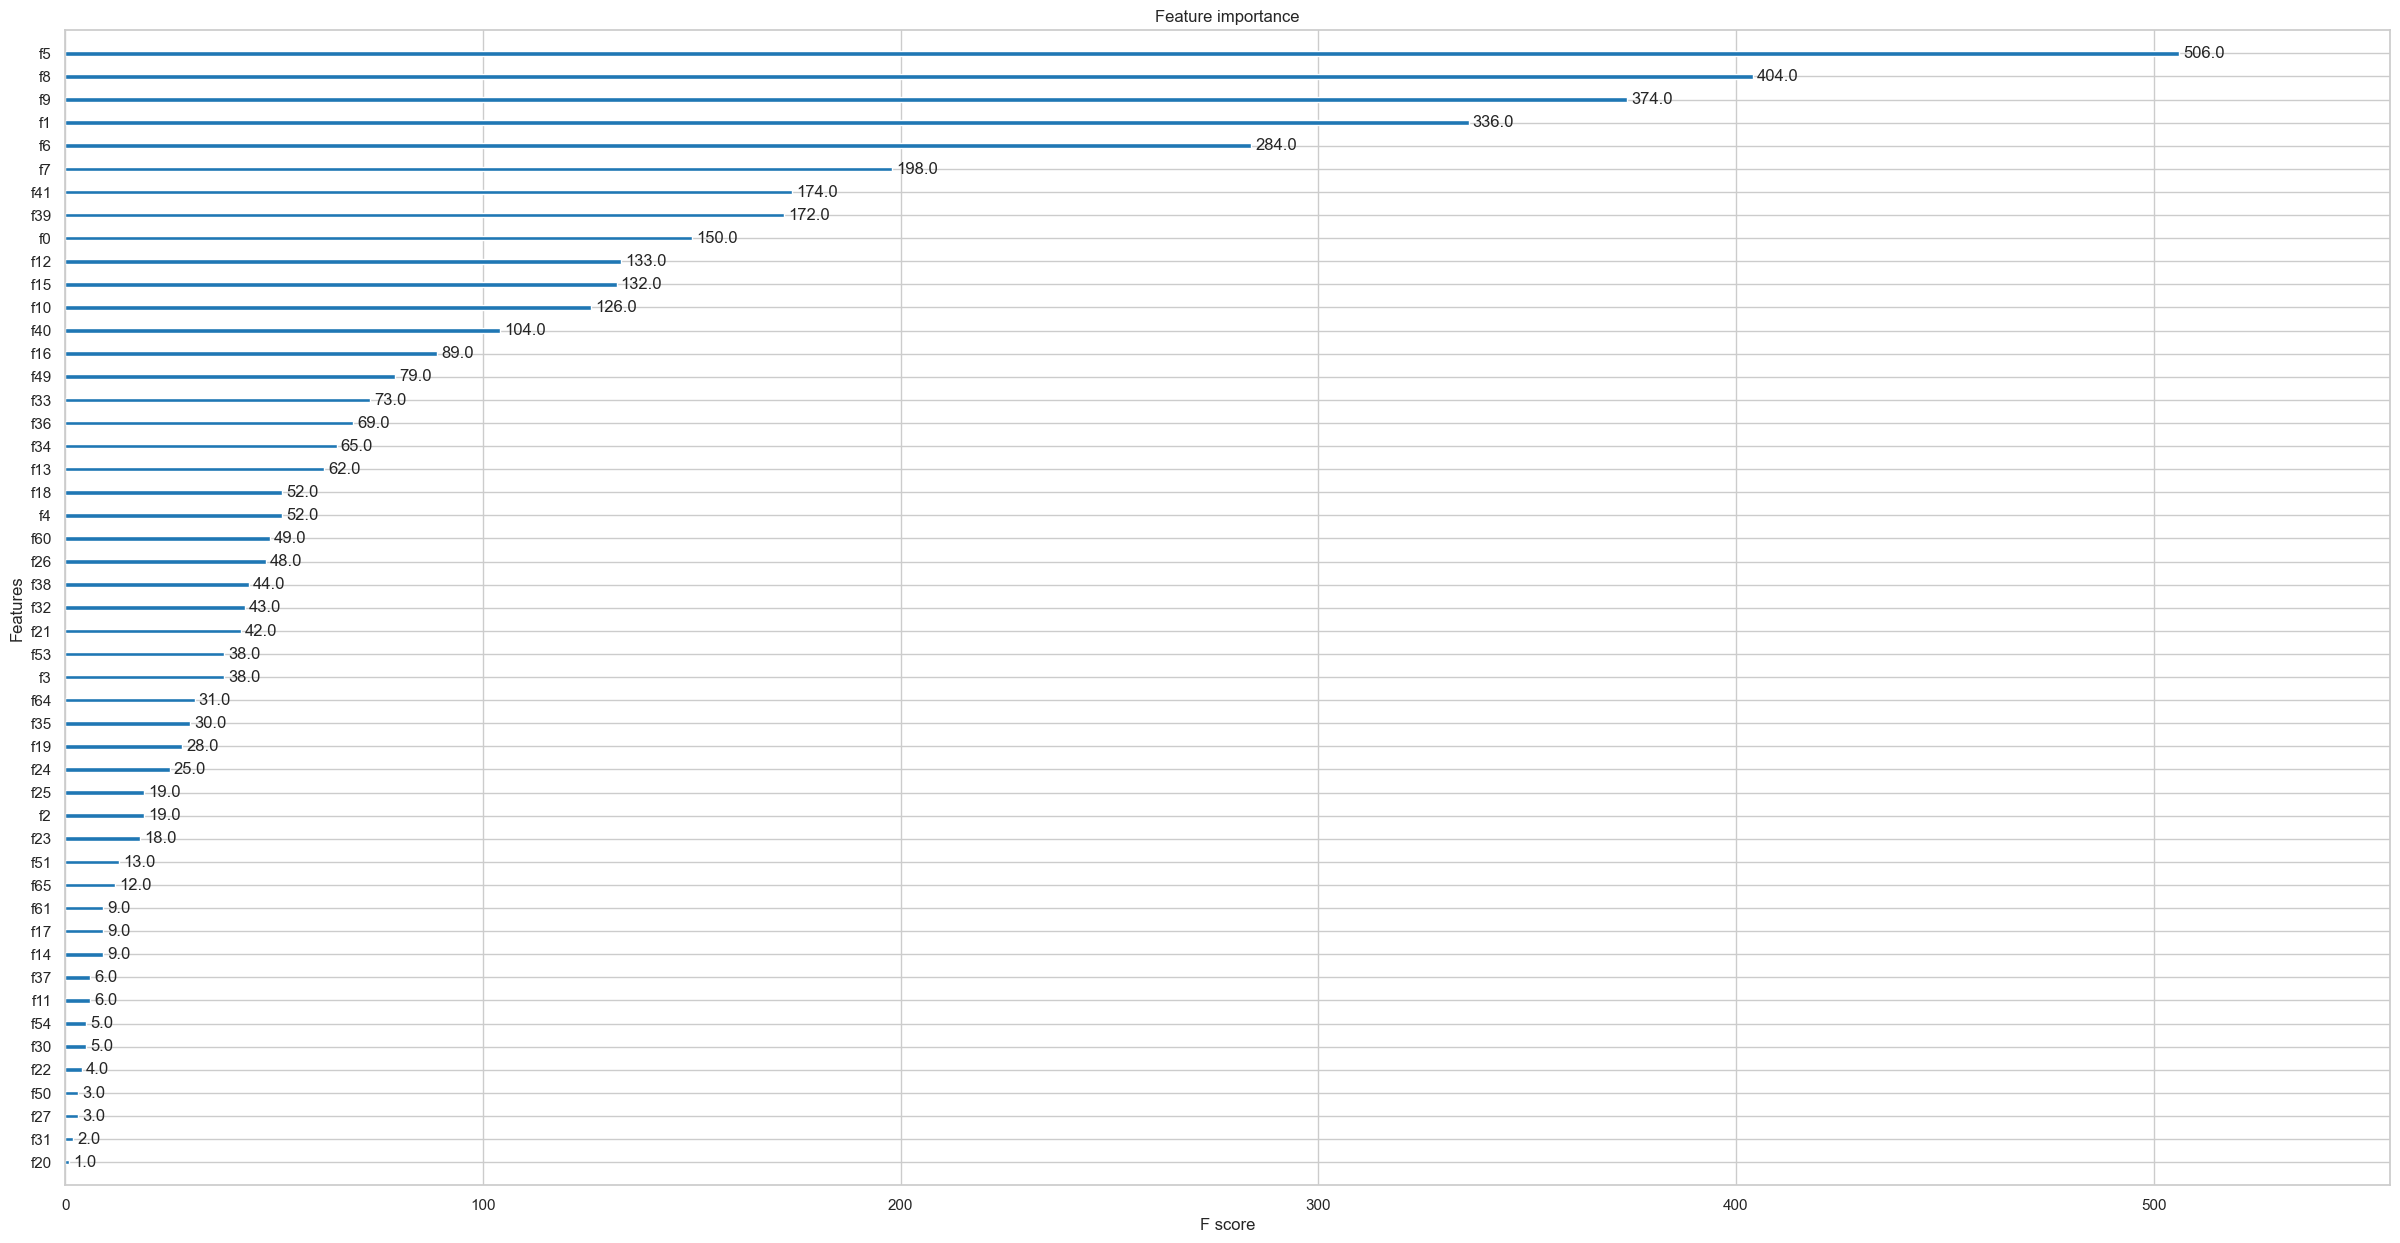

In [156]:
fig, ax = plt.subplots(figsize=(30, 15))

xgb.plot_importance(xgb_final_model, ax=ax)
plt.show()

In [157]:
feature_names_xgb = train_set_extended.drop(['Price_log', 'Price'], axis=1).columns.values
feature_names_xgb = feature_names_xgb[xgb_final_model.feature_importances_.argsort()]

In [158]:
feature_names_xgb = feature_names_xgb[:22]

X_train_set_xgb = train_set_extended[feature_names_xgb]
X_train_set_xgb = xgb_scaler.fit_transform(X_train_set_xgb)

In [159]:
feature_names_xgb

array(['location_group_price_median_log_prop', 'YearBuilt_log',
       'Landsize_log', 'Car_log', 'Bathroom_log', 'Bedroom2_log',
       'Rooms_log', 'BuildingArea_log',
       'councilarea_price_median_log_prop', 'Distance_sqr',
       'location_group_price_mean_log_prop', 'Landsize_sqr',
       'BuildingArea_sqr', 'Regionname_South-Eastern Metropolitan',
       'Regionname_Other', 'Propertycount_sqr', 'prop_count_bkt',
       'location_group_price_median_prop',
       'prop_count_bkt_price_mean_log_prop',
       'prop_count_bkt_price_median_log_prop', 'Bathroom', 'Bedroom2'],
      dtype=object)

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV

param_grid = { 
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [ 0.3, 0.5 , 0.8 ],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [0, 0.5, 1, 5, 10, 20],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [0, 0.5, 1, 5],
    'max_depth': [3, 6, 10, 15, 20],
    'n_estimators': [50, 100, 300, 500]
}

# Want to be very precise
scoring = ['neg_mean_squared_error']

grid_search_xgb = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid, 
    scoring=scoring, 
    refit=scoring[0], # in recall before
    n_jobs=-1, 
    cv=3, 
    verbose=-1
)

grid_search_xgb = grid_search_xgb.fit(X_train_set_xgb, Y_train_set_xgb)

In [161]:
best_model_xgb = xgb.XGBRegressor(**grid_search_xgb.best_params_).fit(X_train_set_xgb, Y_train_set_xgb)

In [162]:
mean_squared_error(np.exp(best_model_xgb.predict(X_train_set_xgb)), np.exp(Y_train_set_xgb), squared=False)

220205.41180140866

In [163]:
Y_valid_set_xgb = valid_set_extended.Price_log
X_valid_set_xgb = valid_set_extended[feature_names_xgb]

In [164]:
X_valid_set_xgb = xgb_scaler.transform(X_valid_set_xgb)

mean_squared_error(np.exp(best_model_xgb.predict(X_valid_set_xgb)), np.exp(Y_valid_set_xgb), squared=False)

291654.1591262131

- 198566 in train set score, 297286 in valid set score. 18 features
- 223900 in train set score, 296663 in valid set score. 22 features
- 220205, 291654 with 22 features

In [165]:
X_test_set_xgb = test_set_extended[feature_names_xgb]
X_test_set_xgb = xgb_scaler.transform(X_test_set_xgb)

### CatBoost

In [166]:
import catboost as cb

In [167]:
cb_train = cb.Pool(X_train_set_xgb, Y_train_set_xgb)
cb_test = cb.Pool(X_valid_set_xgb, Y_valid_set_xgb)

In [168]:
grid = {
    # 'iterations': [50, 100, 150, 200, 250],
    'learning_rate': [0.01, 0.03, 0.1],
    'depth': [2, 4, 6, 8, 10, 12],
    'l2_leaf_reg': [0.2, 0.5, 1, 3],
    'n_estimators': [300, 500, 1000, 2000],
}

cat_model = cb.CatBoostRegressor(
    random_seed=1,
    loss_function='RMSE',
    logging_level='Silent'
)

# Train the model with grid search, and select the best one
best_cat_hp = cat_model.randomized_search(
    grid, 
    cb_train, 
    verbose=0,
)

In [169]:
pred_cat = np.exp(cat_model.predict(X_train_set_xgb))
print(mean_squared_error(np.exp(Y_train_set_xgb), pred_cat, squared=False))
print(r2_score(np.exp(Y_train_set_xgb), pred_cat))

207170.78907107527
0.8969584287607663


In [170]:
pred_cat = np.exp(cat_model.predict(X_valid_set_xgb))
print(mean_squared_error(np.exp(Y_valid_set_xgb), pred_cat, squared=False))
print(r2_score(np.exp(Y_valid_set_xgb), pred_cat))

278514.5161993904
0.8197910210903158


In [171]:
best_model_cat = cb.CatBoostRegressor(**cat_model.get_params())

In [172]:
best_model_cat.fit(X_train_set_xgb, Y_train_set_xgb)

In [173]:
mean_squared_error(np.exp(best_model_cat.predict(X_train_set_xgb)), np.exp(Y_train_set_xgb), squared=False)

207170.78907107527

In [174]:
mean_squared_error(np.exp(best_model_cat.predict(X_valid_set_xgb)), np.exp(Y_valid_set_xgb), squared=False)

278514.5161993904

In [175]:
mean_absolute_error(np.exp(best_model_cat.predict(X_valid_set_xgb)), np.exp(Y_valid_set_xgb))

170120.3278319545

### Model Stacking

Now we have different models that seem to have very good 

In [176]:
# And now we will stack the best models we had so far
best_model_lr = HuberRegressor().fit(X_train_set_final_log, Y_train_set_final_log)
best_model_xgb = xgb.XGBRegressor(**grid_search_xgb.best_params_).fit(X_train_set_xgb, Y_train_set_xgb)
best_model_cat = cb.CatBoostRegressor(**cat_model.get_params()).fit(X_train_set_xgb, Y_train_set_xgb)

In [177]:
from typing import Tuple
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class ModelStacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(
        self, 
        models, 
        features, 
        weights = None
    ):
        self.models = models
        self._models = None
        self.features = features
        self.weights: Tuple[float] = weights if weights else tuple([1/len(models)] * len(models))  # uniform weighting
        
    # Clone aStandardScalerrdScalerrain the models with the features we want 
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for idx, model in enumerate(self.models_):
            model.fit(X[self.features[idx]], y)

        return self
    
    # Average the predictions of the models
    def predict(self, X):
        predictions = np.column_stack([
            np.exp(
                model.predict(X[self.features[idx]])
            ) for idx, model in enumerate(self.models_)
        ])
        
        return np.average(predictions, axis=1, weights=self.weights)   

In [178]:
train_set_final_stack = train_set_extended.copy()
valid_set_final_stack = valid_set_extended.copy()
test_set_final_stack = test_set_extended.copy()

In [179]:
stack_scaler = StandardScaler()

In [ ]:
all_features_stack = [*final_features, *feature_names_xgb]
train_set_final_stack[all_features_stack] = stack_scaler.fit_transform(train_set_final_stack[all_features_stack])
valid_set_final_stack[all_features_stack] = stack_scaler.transform(valid_set_final_stack[all_features_stack])
test_set_final_stack[all_features_stack] = stack_scaler.transform(test_set_final_stack[all_features_stack])

train_set_final_stack.drop(['Price'], axis=1, inplace=True)
valid_set_final_stack.drop(['Price'], axis=1, inplace=True)

train_set_final_stack.head(3)

In [181]:
averaged_models = ModelStacking(
    models = (best_model_lr, best_model_xgb, best_model_cat), 
    features = (final_features, feature_names_xgb, feature_names_xgb),
    weights = (.1, .1, .8)  # add more weight to the cat, which is the one that hass less validation error
)

In [182]:
averaged_models.fit(
    train_set_final_stack.drop(['Price_log'], axis=1),
    train_set_final_stack.Price_log
)

ModelStacking(features=(['Type_u', 'Lattitude', 'YearBuilt_log', 'YearBuilt',
                         'Regionname_Western Metropolitan', 'Distance',
                         'Regionname_Northern Metropolitan', 'Distance_sqr',
                         'location_group', 'Regionname_Other', 'Landsize_sqr',
                         'Landsize_log', 'prop_count_bkt_price_median_prop',
                         'prop_count_bkt_price_median_log_prop',
                         'years_to_sell', 'prop_count_bkt_price_mean_...
                                   learning_rate=None, max_bin=None,
                                   max_cat_threshold=None,
                                   max_cat_to_onehot=None, max_delta_step=None,
                                   max_depth=3, max_leaves=None,
                                   min_child_weight=None, missing=nan,
                                   monotone_constraints=None, n_estimators=500,
                                   n_jobs=None, num_parallel_tree=None,
                                   predictor=None, random_state=None, ...),
                      <catboost.core.CatBoostRegressor object at 0x7f9b5b7a5490>),
              weights=(0.1, 0.1, 0.8))

In [183]:
stack_predictions = averaged_models.predict(valid_set_final_stack.drop(['Price_log'], axis=1))

In [184]:
mean_squared_error(stack_predictions, np.exp(valid_set_final_stack.Price_log), squared=False)

278665.2598842112

And what if with trying to predict the price logarithm, we divided into different types of houses, and create stack of models to predict each one of them.

In [185]:
train_set_final_type = train_set_extended.copy()
valid_set_final_type = valid_set_extended.copy()
test_set_final_type = test_set_extended.copy()

<AxesSubplot:xlabel='Type', ylabel='Price_log'>

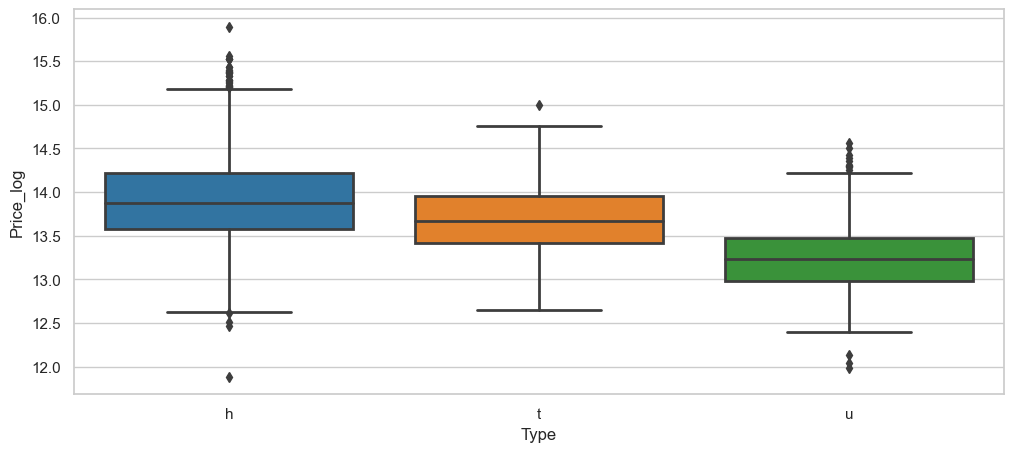

In [186]:
sns.boxplot(x="Type", y="Price_log", data=train_set)

In [187]:
def divide_type(df: pd.DataFrame):
    type_t = df[df.Type_t == 1]
    type_u = df[df.Type_u == 1]
    type_h = df[
        (df.Type_u == 0) & 
        (df.Type_t == 0)
    ]
    
    return type_t, type_u, type_h

In [188]:
type_t_train, type_u_train, type_h_train = divide_type(train_set_final_type)

In [189]:
print('Shapes T: ', type_t_train.shape)
print('Shapes U: ', type_u_train.shape)
print('Shapes H: ', type_h_train.shape)

Shapes T:  (415, 71)
Shapes U:  (999, 71)
Shapes H:  (3203, 71)


In [190]:
from sklearn.utils import resample

type_t_train_upsample = resample(
    type_t_train,
    replace=True,
    n_samples=int(len(type_h_train) * .7),
    random_state=42
)

type_u_train_upsample = resample(
    type_u_train,
    replace=True,
    n_samples=int(len(type_h_train) * .7),
    random_state=42
)

In [191]:
print('Shapes T: ', type_t_train_upsample.shape)
print('Shapes U: ', type_u_train_upsample.shape)
print('Shapes H: ', type_h_train.shape)

Shapes T:  (2242, 71)
Shapes U:  (2242, 71)
Shapes H:  (3203, 71)


In [192]:
train_set_final_type_upsampled = pd.concat([type_t_train_upsample, type_u_train_upsample, type_h_train], axis=0)

In [193]:
types_df_dict_train = {
    't': type_t_train_upsample,
    'u': type_u_train_upsample,
    'h': type_h_train
}

In [194]:
# We will not use then this value
final_features_types = [feature for feature in final_features if not feature.startswith('Type_')]
feature_names_xgb_types = [feature for feature in feature_names_xgb if not feature.startswith('Type_')]

all_features_types = list(set(final_features_types + feature_names_xgb_types))

In [195]:
types_model_dict = dict()

for house_type in types_df_dict_train.keys():
    df = types_df_dict_train[house_type]
    
    # Create a new model stacking
    new_model_stacking = ModelStacking(
        models = (best_model_lr, best_model_xgb, best_model_cat), 
        features = (final_features_types, feature_names_xgb_types, feature_names_xgb_types),
        weights = (.25, .25, .5)  # add more weight to the cat, which is the one that hass less validation error
    )
    
    # Train this model with the part of the data
    new_model_stacking.fit(
        df.drop(['Price_log'], axis=1),
        df.Price_log
    )
    
    # And save this model on the dict
    types_model_dict[house_type] = new_model_stacking

In [196]:
# And now we could compute the validation
types_scaler_dict = dict()
for house_type in types_df_dict_train.keys():
    scaler_type = StandardScaler()
    
    df = types_df_dict_train[house_type]
    
    types_scaler_dict[house_type] = scaler_type.fit(df[all_features_types])

In [197]:
type_t_valid, type_u_valid, type_h_valid = divide_type(valid_set_final_type)

In [198]:
types_df_dict_valid = {
    't': type_t_valid,
    'u': type_u_valid,
    'h': type_h_valid
}

for house_type in types_df_dict_valid.keys():
    df = types_df_dict_valid[house_type]
    
    df[all_features_types] = types_scaler_dict[house_type].transform(df[all_features_types])
    
    types_df_dict_valid[house_type] = df[all_features_types]

In [199]:
# And now we compute the predictions and store in a new df
valid_pred = pd.DataFrame(
    columns=['pred', 'actual'], 
    index=valid_set_final_type.index.values
)

In [200]:
for house_type in types_df_dict_valid.keys():
    df = types_df_dict_valid[house_type]
    stacked_model = types_model_dict[house_type]
    valid_pred.loc[df.index, 'pred'] = stacked_model.predict(df)
    valid_pred.loc[df.index, 'actual'] = np.exp(valid_set_final_type.Price_log)

In [201]:
mean_squared_error(valid_pred['pred'], valid_pred['actual'], squared=False)

902760.520653026

## Model Creation: Price Logistic

We could scale the price range from 0-1, and then create a logistic regression that is bounded between the minimum value of the price and the maximum value.

We could do this jointly the clustering, so each price is bounded to the area of the prices. 

In [202]:
train_set_final_logit = train_set_extended.copy()
valid_set_final_logit = valid_set_extended.copy()
test_set_final_logit = test_set_extended.copy()

In [ ]:
percentile_price_train = train_set_final_logit.Price.quantile(.98)
outliers = train_set_final_logit[train_set_final_logit.Price > percentile_price_train]
print(round(percentile_price_train, 2))
print(outliers.shape)
outliers.head()

In [205]:
def classify_k_clusters(
    train_set: pd.DataFrame, 
    valid_set: pd.DataFrame, 
    test_set: pd.DataFrame, 
    outliers: pd.DataFrame,
    n_features: int = 10,
    features: List[str] = ['Longtitude', 'Lattitude'],
):
    print('Number of features: ', n_features)
    
    scaler = MinMaxScaler()
    
    # Train the model
    k_means_logit = KMeans(
        n_clusters=n_features, 
        n_init='auto',
        max_iter=1000
    )

    train_set_scaled = scaler.fit_transform(train_set[features])
    valid_set_scaled = scaler.transform(valid_set[features])
    test_set_scaled = scaler.transform(test_set[features])
    
    k_means_logit.fit(train_set_scaled)
    
    labels_train = k_means_logit.labels_
    labels_valid = k_means_logit.predict(valid_set_scaled)
    labels_test = k_means_logit.predict(test_set_scaled)
    
    train_set['location_group_logit'] = labels_train
    valid_set['location_group_logit'] = labels_valid
    test_set['location_group_logit'] = labels_test
    
    # Plot the results
    # Where are those extreme percentiles located
    for label in range(n_features):
        plt.scatter(
            train_set.loc[(train_set.location_group_logit == label).values, 'Longtitude'], 
            train_set.loc[(train_set.location_group_logit == label).values, 'Lattitude'], 
            label = f"{label} cluster",
        )

    plt.scatter(
        outliers.loc[:, 'Longtitude'],
        outliers.loc[:, 'Lattitude'], 
        label='outliers', 
        color = 'k', 
        s=10
    )

    plt.legend(
        prop={'size': 8}
    )
    plt.show()
    
    return train_set, valid_set, test_set

Number of features:  10


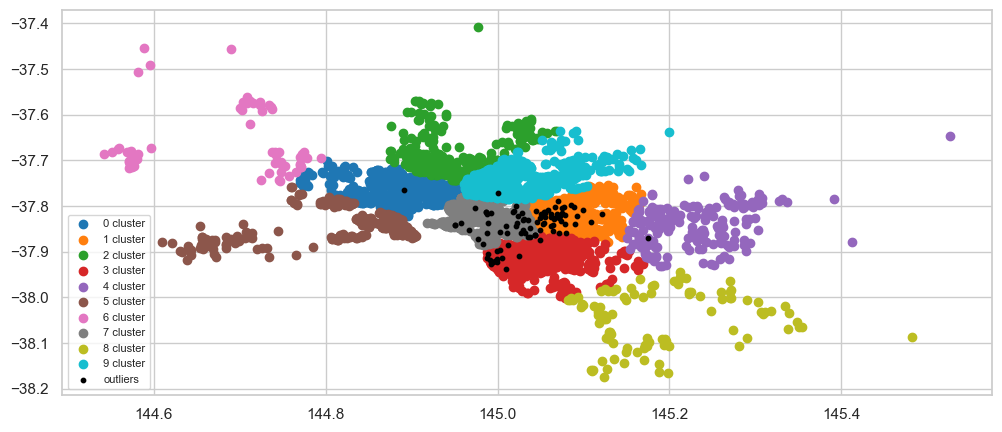

In [206]:
(
    train_set_final_logit, 
    valid_set_final_logit, 
    test_set_final_logit
) = classify_k_clusters(train_set_final_logit, valid_set_final_logit, test_set_final_logit, outliers)

In [207]:
# And now, based on this clustering, we will min-max scale the prices
location_group_logit_max_price = train_set_final_logit.groupby('location_group_logit').max()['Price']
location_group_logit_max_price.head(3)

location_group_logit
0    3400000.0
1    8000000.0
2    1400000.0
Name: Price, dtype: float64

So this way, what the model should be able to do is to predict instead of the price value, the score of the price with respect the area in which the house is.

In [208]:
def set_logit_column(
    df: pd.DataFrame, 
    target_column: str = 'Price', 
    group_logits = location_group_logit_max_price
):
    
    for idx, row in df.iterrows():
        value = row[target_column]
        cluster_logit = row.location_group_logit

        df.loc[
            idx, 
            str(target_column + '_logit').lower()
        ] = value / group_logits[cluster_logit]
        
    return df

In [209]:
# From respect the prices
train_set_final_logit = set_logit_column(train_set_final_logit)
valid_set_final_logit = set_logit_column(valid_set_final_logit)

We will now min-max scale the other variables that seem to be interesting.

In [211]:
train_set_final_logit = train_set_final_logit.drop(['Price', 'Price_log'], axis=1)
valid_set_final_logit = valid_set_final_logit.drop(['Price', 'Price_log'], axis=1)

In [212]:
# We can do the same we have done for the prices, but for other values as well: Landsize, BuildingArea, Distance
percentile_building_area_train = train_set_final_logit.groupby('location_group_logit').max()['BuildingArea']
train_set_final_logit = set_logit_column(train_set_final_logit, 'BuildingArea', percentile_building_area_train)
valid_set_final_logit = set_logit_column(valid_set_final_logit, 'BuildingArea', percentile_building_area_train)
test_set_final_logit = set_logit_column(test_set_final_logit, 'BuildingArea', percentile_building_area_train)

percentile_landsize_train = train_set_final_logit.groupby('location_group_logit').max()['Landsize']
train_set_final_logit = set_logit_column(train_set_final_logit, 'Landsize', percentile_landsize_train)
valid_set_final_logit = set_logit_column(valid_set_final_logit, 'Landsize', percentile_landsize_train)
test_set_final_logit = set_logit_column(test_set_final_logit, 'Landsize', percentile_landsize_train)

percentile_distance_train = train_set_final_logit.groupby('location_group_logit').max()['Distance']
train_set_final_logit = set_logit_column(train_set_final_logit, 'Distance', percentile_distance_train)
valid_set_final_logit = set_logit_column(valid_set_final_logit, 'Distance', percentile_distance_train)
test_set_final_logit = set_logit_column(test_set_final_logit, 'Distance', percentile_distance_train)

In [213]:
corr_final_logit = train_set_final_logit.corr().sort_values('price_logit')['price_logit']
corr_final_logit

Type_u                                  -0.489662
location_group_price_mean_prop          -0.301990
distance_logit                          -0.291576
location_group_price_median_prop        -0.283853
location_group_price_mean_log_prop      -0.281469
location_group_price_median_log_prop    -0.280791
Regionname_Southern Metropolitan        -0.245083
councilarea_price_median_log_prop       -0.162906
councilarea_price_mean_prop             -0.159798
councilarea_price_median_prop           -0.156435
councilarea_price_mean_log_prop         -0.147386
council_class                           -0.110590
YearBuilt_log                           -0.096693
YearBuilt                               -0.095883
Type_t                                  -0.090285
location_group                          -0.087195
Longtitude                              -0.077327
Propertycount_sqr                       -0.040391
Propertycount                           -0.038113
suburb_price_mean_prop                  -0.026543


In [214]:
features_logit_scale = [
    'Rooms',
    'Distance',
    'Bedroom2',
    'Bathroom',
    'Car',
    'Landsize',
    'quarter_sold',
    'seller_class',
    'suburb_class',
    # Ratios
    'bed_bath_ratio', 'car_bed_ratio', 'bed_room_ratio', 'bath_room_ratio', 'room_building_area_ratio', 'bed_building_area_ratio', 'bath_building_area_ratio',
    # Logarithms
    'Bedroom2_log', 'Bathroom_log', 'Car_log', 'Landsize_log', 'YearBuilt_log'
]

features_logit_other = [
    # Proportions: possible information that those categories could bring
    # 'sellerg_price_mean_prop',      --> creates lot of overfit
    # 'suburb_price_mean_prop',       --> creates lot of overfit
    # 'councilarea_price_mean_prop',  --> creates lot of overfit
    # Categorical variables made with one-hot encoding
    'Resold', 'Method_S', 'Method_SA', 'Method_SP', 'Method_VB', 
    'Type_t', 'Type_u', 
    'Regionname_Northern Metropolitan', 'Regionname_Other', 'Regionname_South-Eastern Metropolitan', 'Regionname_Southern Metropolitan', 'Regionname_Western Metropolitan',
    # Other logits already from 0-1
    'buildingarea_logit',
    'landsize_logit',
    'distance_logit'
]

features_logit = features_logit_scale + features_logit_other

In [215]:
scaler_logit = MinMaxScaler()
train_set_final_logit = train_set_final_logit[features_logit + ['price_logit', 'location_group_logit']]
train_set_final_logit[features_logit_scale] = scaler_logit.fit_transform(train_set_final_logit[features_logit_scale])

In [216]:
Y_train_set_final_logit = train_set_final_logit['price_logit']
X_train_set_final_logit = train_set_final_logit[features_logit]

### KNN

In [217]:
model_knn_logit = KNeighborsRegressor().fit(
    X_train_set_final_logit, 
    Y_train_set_final_logit
)

In [218]:
def get_price_logit(
    df_x: pd.DataFrame, 
    df_pred: pd.DataFrame, 
    group_logits,
    column_to_transform: str = 'pred'
):
    for idx, row in df_x.iterrows():
        value = df_pred.loc[idx, column_to_transform]
        cluster_logit = row.location_group_logit
        df_pred.loc[
            idx, 
            'final_price'
        ] = value * group_logits[cluster_logit]
    
    return df_pred

In [219]:
train_logit_predictions = model_knn_logit.predict(X_train_set_final_logit)

In [220]:
train_logit_predictions_real = get_price_logit(train_set_final_logit, pd.DataFrame(
    train_logit_predictions, 
    columns=['pred'],
    index=train_set_final_logit.index.values
), location_group_logit_max_price)

In [221]:
Y_train_set_final_logit_real = get_price_logit(train_set_final_logit, pd.DataFrame(
    Y_train_set_final_logit.values, 
    columns=['actual'],
    index=train_set_final_logit.index.values,
), location_group_logit_max_price, 'actual')

In [222]:
mean_squared_error(
    train_logit_predictions_real['final_price'], 
    Y_train_set_final_logit_real['final_price'], 
    squared=False
)

338105.24248516187

In [223]:
# And now we will try with the validation set
valid_set_final_logit = valid_set_final_logit[features_logit + ['price_logit', 'location_group_logit']]
valid_set_final_logit[features_logit_scale] = scaler_logit.transform(valid_set_final_logit[features_logit_scale])

Y_valid_set_final_logit = valid_set_final_logit['price_logit']
X_valid_set_final_logit = valid_set_final_logit[features_logit]

In [224]:
valid_logit_predictions = model_knn_logit.predict(X_valid_set_final_logit)

valid_logit_predictions_real = get_price_logit(valid_set_final_logit, pd.DataFrame(
    valid_logit_predictions, 
    columns=['pred'],
    index=valid_set_final_logit.index.values
), location_group_logit_max_price)

Y_valid_set_final_logit_real = get_price_logit(valid_set_final_logit, pd.DataFrame(
    Y_valid_set_final_logit.values, 
    columns=['actual'],
    index=valid_set_final_logit.index.values,
), location_group_logit_max_price, 'actual')

In [225]:
mean_squared_error(
    valid_logit_predictions_real['final_price'], 
    Y_valid_set_final_logit_real['final_price'], 
    squared=False
)

445308.26303468534

### XGBoost

In [226]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV

# Outliers will less affect to us (we cap the maximum price)
scoring_logit = ['neg_mean_absolute_error']

grid_search_xgb_logit = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:logistic'),
    param_grid=param_grid, 
    scoring=scoring_logit, 
    refit=scoring_logit[0], # in recall before
    n_jobs=-1, 
    cv=3, 
    verbose=-1
)

grid_search_xgb_logit = grid_search_xgb_logit.fit(X_train_set_final_logit, Y_train_set_final_logit)

In [227]:
best_model_xgb_logit = xgb.XGBRegressor(**grid_search_xgb_logit.best_params_, objective='reg:logistic').fit(
    X_train_set_final_logit, 
    Y_train_set_final_logit
)

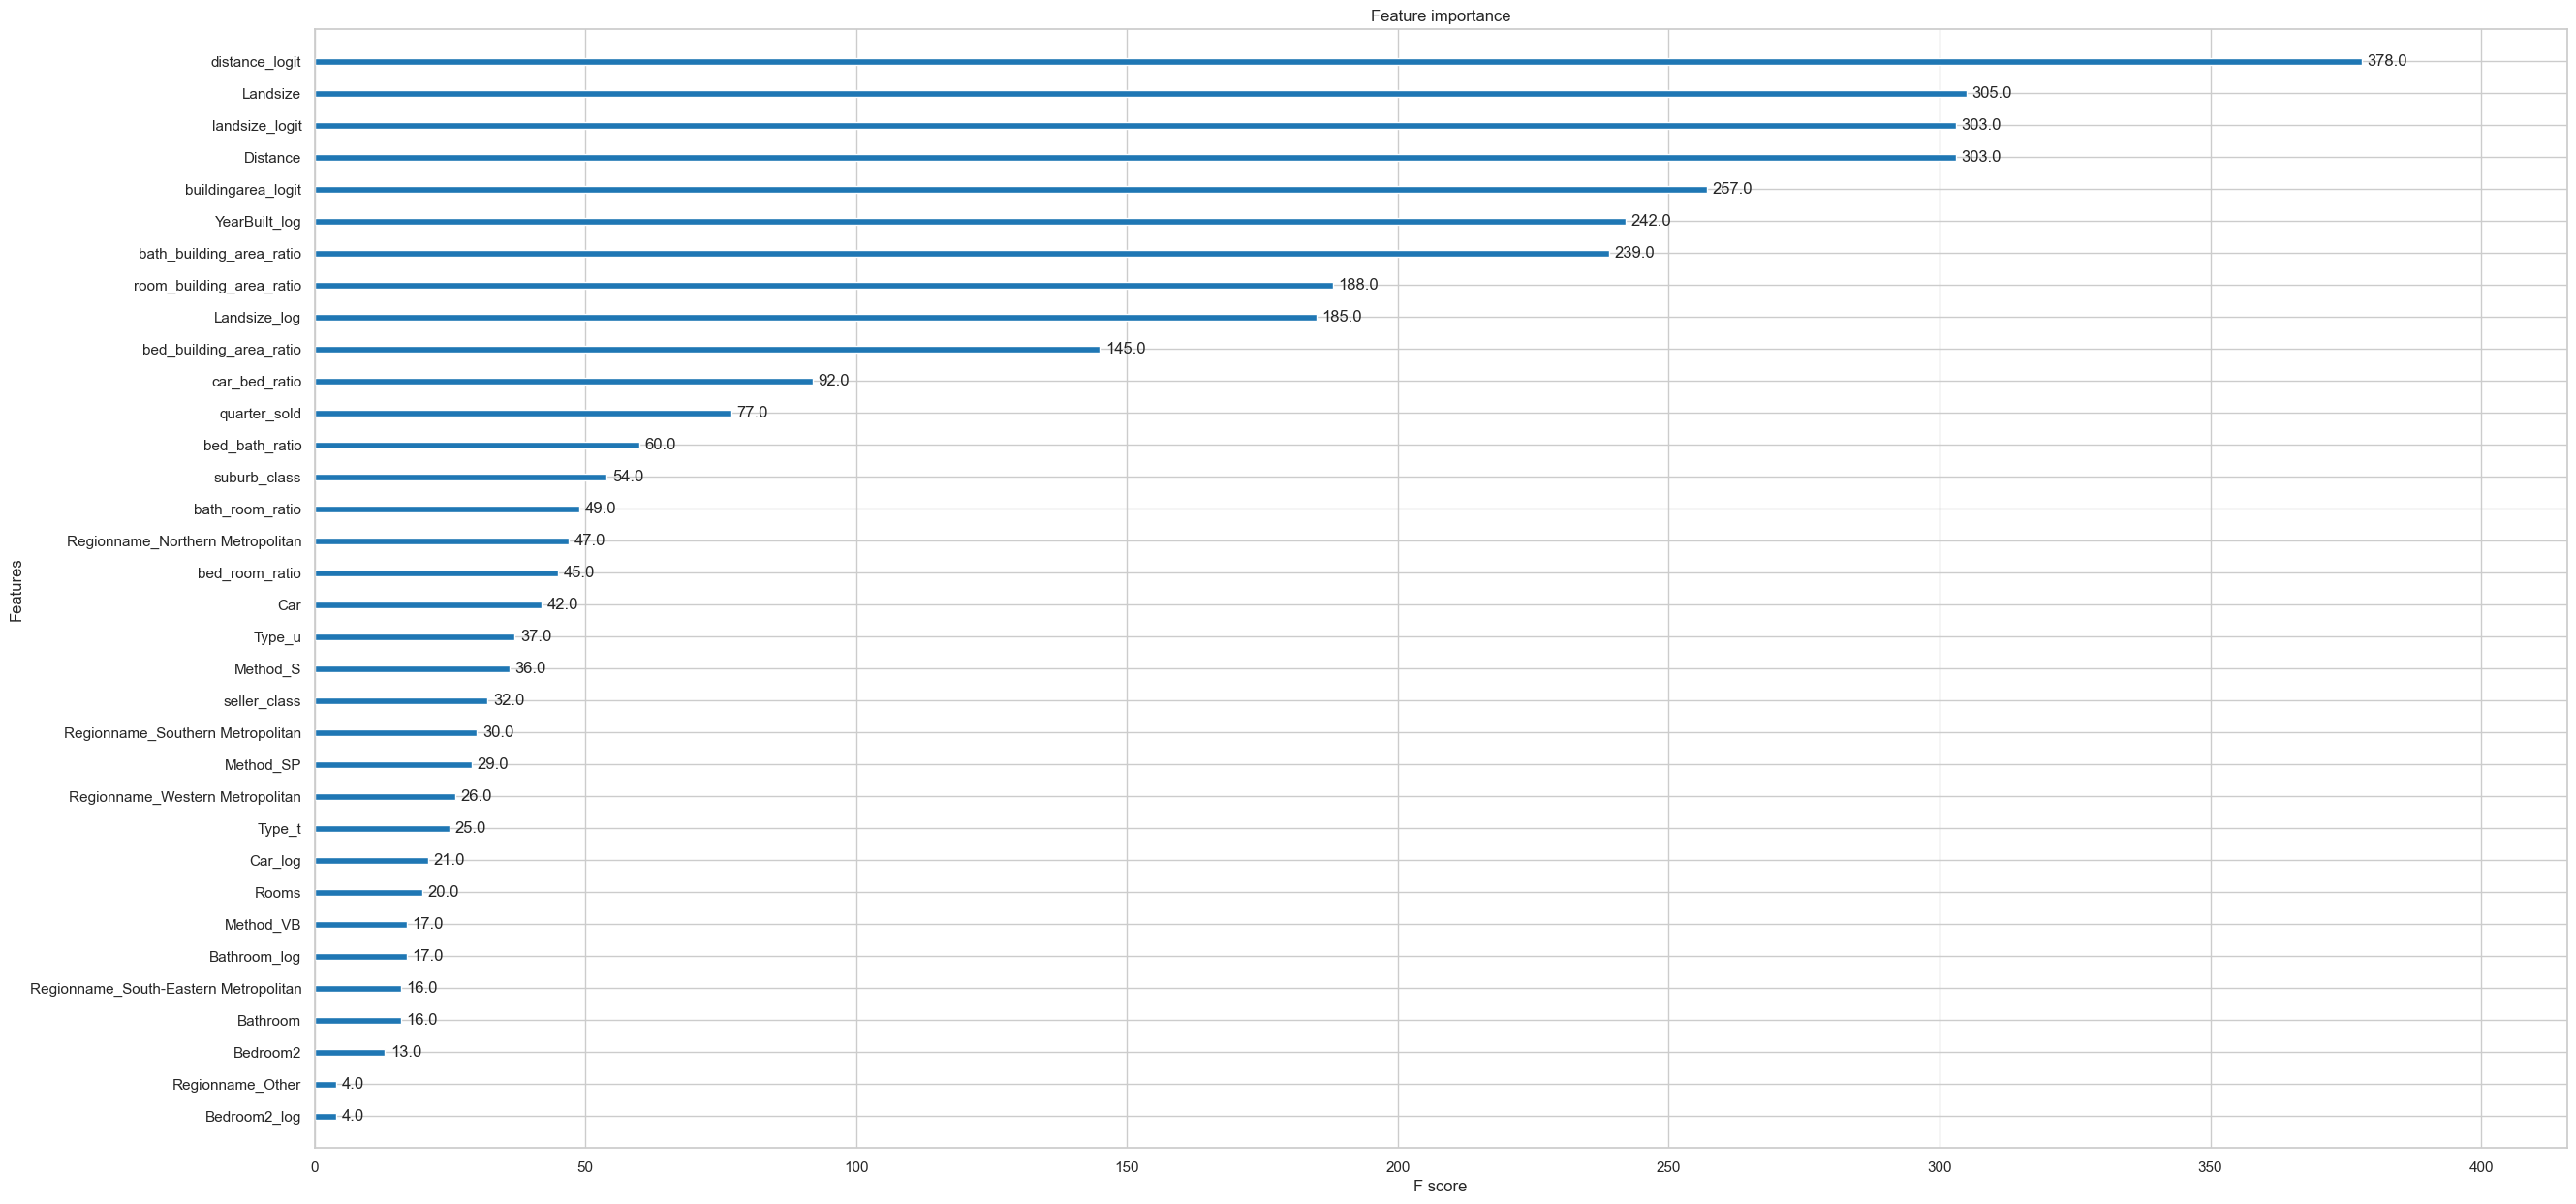

In [228]:
fig, ax = plt.subplots(figsize=(30, 15))

xgb.plot_importance(best_model_xgb_logit, ax=ax)
plt.show()

In [229]:
# Will try first which is the error on the training
train_logit_predictions = best_model_xgb_logit.predict(X_train_set_final_logit)

In [230]:
train_logit_predictions_real = get_price_logit(train_set_final_logit, pd.DataFrame(
    train_logit_predictions, 
    columns=['pred'],
    index=train_set_final_logit.index.values
), location_group_logit_max_price)

In [231]:
Y_train_set_final_logit_real = get_price_logit(train_set_final_logit, pd.DataFrame(
    Y_train_set_final_logit.values, 
    columns=['actual'],
    index=train_set_final_logit.index.values,
), location_group_logit_max_price, 'actual')

In [232]:
mean_squared_error(
    train_logit_predictions_real['final_price'], 
    Y_train_set_final_logit_real['final_price'], 
    squared=False
)

193818.3284812936

In [233]:
valid_logit_predictions = best_model_xgb_logit.predict(X_valid_set_final_logit)

valid_logit_predictions_real = get_price_logit(valid_set_final_logit, pd.DataFrame(
    valid_logit_predictions, 
    columns=['pred'],
    index=valid_set_final_logit.index.values
), location_group_logit_max_price)

Y_valid_set_final_logit_real = get_price_logit(valid_set_final_logit, pd.DataFrame(
    Y_valid_set_final_logit.values, 
    columns=['actual'],
    index=valid_set_final_logit.index.values,
), location_group_logit_max_price, 'actual')

In [234]:
mean_squared_error(
    valid_logit_predictions_real['final_price'], 
    Y_valid_set_final_logit_real['final_price'], 
    squared=False
)

286941.04285314685

In [235]:
mean_absolute_error(
    valid_logit_predictions_real['final_price'], 
    Y_valid_set_final_logit_real['final_price'], 
)

178323.62581624795

In [236]:
r2_score(
    train_logit_predictions_real['final_price'], 
    Y_train_set_final_logit_real['final_price']
)

0.8947845196270421

In [237]:
r2_score(
    valid_logit_predictions_real['final_price'], 
    Y_valid_set_final_logit_real['final_price']
)

0.7620016836886152

We can try also for the testing.

In [238]:
test_set_final_logit = test_set_final_logit[features_logit + ['location_group_logit']]
test_set_final_logit[features_logit_scale] = scaler_logit.transform(test_set_final_logit[features_logit_scale])

X_test_set_final_logit = test_set_final_logit[features_logit]

### Final Model

After trying all of these approaches, we will go do the stack models for logarithms prices.

In [250]:
# lr_final_model = Ridge().fit(X_train_set_final, Y_train_set_final)
submission = pd.DataFrame(averaged_models.predict(test_set_final_stack))
submission = submission.reset_index()
submission.columns = ['index', 'Price']
submission.to_csv('Submissions.csv', index=False)
submission

,index,Price
0,0,2.023643e+06
1,1,5.531563e+05
2,2,1.066414e+06
3,3,5.670052e+05
4,4,6.927188e+05
...,...,...
8143,8143,1.050963e+06
8144,8144,5.939521e+05
8145,8145,6.739012e+05
8146,8146,5.573665e+05


In [239]:
!pip3 install nbconvert[qtpdf]

zsh:1: no matches found: nbconvert[qtpdf]
